# Libraries and Modules

In [209]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
## Linear Regression is used as a baseline model
from sklearn.linear_model import LinearRegression

## Random Forest, XGB and Gradient Boosting are experimented for better performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

## Support Vector Machine is useful for non-linear data
from sklearn.svm import SVR


# Model Parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Model Evaluation
## For Regression Models we use MAE, MSE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [210]:
pd.set_option('display.max_columns', None)

Recommendations

Begin with Linear Regression as a baseline.

Experiment with Random Forest and XGBoost/LightGBM for better performance.

If you suspect non-linear relationships, try SVR or Neural Networks.

Use Ensemble methods for combining predictions from multiple models.

# Data Import

In [211]:
df_test = pd.read_csv(r'Dataset\Test_dataset.csv')
df_train = pd.read_csv(r'Dataset\Train_dataset.csv')

In [212]:
df_test.shape

(500, 33)

# Exploratory Data Analysis (EDA)

## 1. Data Structure
- Columns: Check column data, compare test with train data
- Data Types: Check the data types of each column.
- Missing Values: Identify and handle missing values.
- Basic Statistics: Calculate basic statistics like mean, median, standard deviation, etc.

### a) Columns

In [213]:
train_columns = set(df_train.columns)
test_columns = set(df_test.columns)

# Identify columns present in train but missing in test
missing_in_test = train_columns - test_columns

# Identify columns present in test but missing in train
missing_in_train = test_columns - train_columns

# Print the results
if missing_in_test:
    print("Columns present in train but missing in test:")
    print(missing_in_test)
else:
    print("No columns are missing in test dataset.")

if missing_in_train:
    print("Columns present in test but missing in train:")
    print(missing_in_train)
else:
    print("No columns are missing in train dataset.")

Columns present in train but missing in test:
{'Endorsed By', 'Annual Turnover'}
Columns present in test but missing in train:
{'Endoresed By'}


In [214]:
# Fix the column name
df_test.rename(columns={'Endoresed By':'Endorsed By'}, inplace=True)

### b) Data types

In [215]:
dtype_train = df_train.drop(columns=['Annual Turnover']).dtypes
dtype_test = df_test.dtypes

# Align the indices of the two Series objects
dtype_test = dtype_test.reindex(dtype_train.index)

# Compare data types
dtype_diff = dtype_train.compare(dtype_test)

# Print the differences
if not dtype_diff.empty:
    print("Differences in data types between train and test datasets:")
    print(dtype_diff)
else:
    print("All columns have matching data types in train and test datasets.")

Differences in data types between train and test datasets:
                   self  other
Resturant Tier  float64  int64
Ambience        float64  int64


In [216]:
df_train['Resturant Tier'].value_counts()

Resturant Tier
2.0    3191
1.0     253
Name: count, dtype: int64

In [217]:
df_train['Ambience'].value_counts().sort_index(ascending=False)

Ambience
10.0    167
9.0     348
8.0     665
7.0     596
6.0     679
5.0     368
4.0     349
3.0     150
2.0      96
1.0      29
0.0      21
Name: count, dtype: int64

In [218]:
# Match the data types of the two datasets
df_test['Resturant Tier'] = df_test['Resturant Tier'].astype(float)
df_test['Ambience'] = df_test['Ambience'].astype(float)

# Could not convert train['Ambience'] and train['Resturant Tier'] to int as they contain NaN values

- Note:

Now that data types are alined we can check df_train data types and any changes made will be replicated on to df_test. This step could have been done before checking for differences but I didn't think of it until now and don't want to change it

In [219]:
def change_col_type(col_name, dtype):
    '''
    Change the data type of a column in both train and test datasets.
    '''
    df_train[col_name] = df_train[col_name].astype(dtype)
    df_test[col_name] = df_test[col_name].astype(dtype)

In [220]:
change_col_type('Opening Day of Restaurant', 'datetime64[ns]')

col_bool = ['Fire Audit', 'Liquor License Obtained', 'Situated in a Multi Complex', 'Dedicated Parking', 'Open Sitting Available']

for col in col_bool:
    change_col_type(col, 'bool')

In [221]:
df_test.dtypes

Registration Number                       int64
Cuisine                                  object
City                                     object
Restaurant Location                      object
Opening Day of Restaurant        datetime64[ns]
Facebook Popularity Quotient            float64
Endorsed By                              object
Instagram Popularity Quotient           float64
Fire Audit                                 bool
Liquor License Obtained                    bool
Situated in a Multi Complex                bool
Dedicated Parking                          bool
Open Sitting Available                     bool
Resturant Tier                          float64
Restaurant Type                          object
Restaurant Theme                         object
Restaurant Zomato Rating                  int64
Restaurant City Tier                      int64
Order Wait Time                           int64
Staff Responsivness                       int64
Value for Money                         

- Note:

Since both column types match a final inspection of only one is needed.

### c) Missing Values

In [222]:
df_train.shape

(3493, 34)

In [223]:
# show missing values only
df_train.isna().sum()[df_train.isna().sum() > 0]

Facebook Popularity Quotient       99
Instagram Popularity Quotient      56
Resturant Tier                     49
Overall Restaurant Rating         212
Live Music Rating                 765
Comedy Gigs Rating               2483
Value Deals Rating               2707
Live Sports Rating               3288
Ambience                           25
dtype: int64

In [224]:
df_test.isna().sum()[df_test.isna().sum() > 0]

Overall Restaurant Rating     34
Live Music Rating            102
Comedy Gigs Rating           370
Value Deals Rating           385
Live Sports Rating           471
dtype: int64

- Note: 

A deep dive into the data reveals that the missing values for _Live Music Rating_, _Comedy Gigs Rating_, _Value Deals Rating_, _Live Sports Rating_ means the venue does not offer those services. **New indicator columns will display this difference**. 

The Missing **values will be kept as NaN for the time being** since some models can handle them and others can't, further on the values will be changed depending on the model's requirements.

_Overall Resturant Rating_ missing values will be **dropped**.

In [225]:
# Create a new column indicating whether the service is available
def create_has_service(col_name):
    '''
    Create a new column indicating whether the service is available and removing 'Rating' from new colummns name.
    '''
    df_train['Has ' + col_name.replace(' Rating','')] = df_train[col_name].notna()
    df_test['Has ' + col_name.replace(' Rating','')] = df_test[col_name].notna()

In [226]:
services_cols = ['Live Music Rating', 'Comedy Gigs Rating', 'Value Deals Rating', 'Live Sports Rating']

for col in services_cols:
    create_has_service(col)

# for services_cols fill NaN values with 0
df_train[services_cols] = df_train[services_cols].fillna(0)
df_test[services_cols] = df_test[services_cols].fillna(0)

In [227]:
# Create new column indicating if has facebook or instagram quotient
def create_has_social_media(col_name):
    '''
    Create a new column indicating whether the service is available and removing 'Rating' from new colummns name.
    '''
    df_train['Has ' + col_name.replace(' Popularity ','')] = df_train[col_name].notna()
    df_test['Has ' + col_name.replace(' Popularity ','')] = df_test[col_name].notna()

In [228]:
social_media_cols = ['Facebook Popularity Quotient', 'Instagram Popularity Quotient']

for col in social_media_cols:
    create_has_social_media(col)

# for social_media_cols fill NaN values with 0
df_train[social_media_cols] = df_train[social_media_cols].fillna(0)

In [229]:
# Drop Overall Restaurant Rating Missing values
df_train.dropna(subset=['Overall Restaurant Rating'], inplace=True)
# fill with 0
df_test['Overall Restaurant Rating'] = df_test['Overall Restaurant Rating'].fillna(0)
#df_test.dropna(subset=['Overall Restaurant Rating'], inplace=True)

In [230]:
# show missing values only
df_train.isna().sum()[df_train.isna().sum() > 0]

Resturant Tier    47
Ambience          23
dtype: int64

In [231]:
# drop resturant tier missing values
df_train.dropna(subset=['Resturant Tier'], inplace=True)

### d) Basic Statistics (describe)

#### Describe Numeric

In [232]:
df_test.shape

(500, 39)

In [233]:
df_train.describe().T

,count,mean,min,25%,50%,75%,max,std
Registration Number,3234.0,61756.663265,60001.0,60886.25,61751.5,62629.5,63492.0,1006.475189
Annual Turnover,3234.0,30723067.408782,3500000.0,18000000.0,30000000.0,37000000.0,400000000.0,21299232.295371
Opening Day of Restaurant,3234,2009-11-23 05:23:15.918367232,1996-10-25 00:00:00,2008-10-28 06:00:00,2010-02-27 12:00:00,2011-03-01 00:00:00,2013-12-25 00:00:00,NaN
Facebook Popularity Quotient,3234.0,75.8597,0.0,71.0,78.8,85.6,97.76,15.851902
Instagram Popularity Quotient,3234.0,73.147328,0.0,65.8,74.0,82.0,98.2,14.319975
Resturant Tier,3234.0,1.927025,1.0,2.0,2.0,2.0,2.0,0.260135
Restaurant Zomato Rating,3234.0,2.69697,0.0,2.0,3.0,3.0,5.0,0.785153
Restaurant City Tier,3234.0,0.303649,0.0,0.0,0.0,1.0,1.0,0.459904
Order Wait Time,3234.0,5.501855,1.0,3.0,5.0,8.0,10.0,2.854904
Staff Responsivness,3234.0,4.522882,1.0,4.0,5.0,5.0,8.0,1.091939


In [234]:
df_test.describe().T

,count,mean,min,25%,50%,75%,max,std
Registration Number,500.0,20250.5,20001.0,20125.75,20250.5,20375.25,20500.0,144.481833
Opening Day of Restaurant,500,2009-12-21 18:28:48.000000256,2003-01-06 00:00:00,2008-11-26 12:00:00,2010-03-28 00:00:00,2011-03-16 06:00:00,2014-05-07 00:00:00,NaN
Facebook Popularity Quotient,500.0,77.54124,46.0,70.575,79.0,85.2325,96.8,10.083617
Instagram Popularity Quotient,500.0,74.75326,47.0,65.915,75.0,83.6,97.2,11.337201
Resturant Tier,500.0,1.932,1.0,2.0,2.0,2.0,2.0,0.251998
Restaurant Zomato Rating,500.0,2.704,1.0,2.0,3.0,3.0,5.0,0.7782
Restaurant City Tier,500.0,0.292,0.0,0.0,0.0,1.0,1.0,0.455138
Order Wait Time,500.0,5.564,1.0,3.0,6.0,8.0,10.0,2.912537
Staff Responsivness,500.0,4.574,2.0,4.0,5.0,5.0,7.0,1.057715
Value for Money,500.0,4.512,2.0,4.0,5.0,5.0,7.0,0.885112


#### Describe Object

In [235]:
df_train.describe(include='object').T

,count,unique,top,freq
Cuisine,3234,20,"tibetan,greek",630
City,3234,281,Bangalore,523
Restaurant Location,3234,2,Near Party Hub,2443
Endorsed By,3234,3,Not Specific,1809
Restaurant Type,3234,3,Bar,3001
Restaurant Theme,3234,22,Arabian,1316


In [236]:
df_test.describe(include=[object]).T

,count,unique,top,freq
Cuisine,500,20,"tibetan,greek",115
City,500,97,Bangalore,74
Restaurant Location,500,2,Near Party Hub,378
Endorsed By,500,3,Not Specific,299
Restaurant Type,500,4,Bar,460
Restaurant Theme,500,18,Arabian,219


## 2. Univariate Analysis
- Distribution of Numerical Features: Use histograms, box plots, and density plots.
- Distribution of Categorical Features: Use bar plots and count plots.

### a) Distribution of Numerical Features

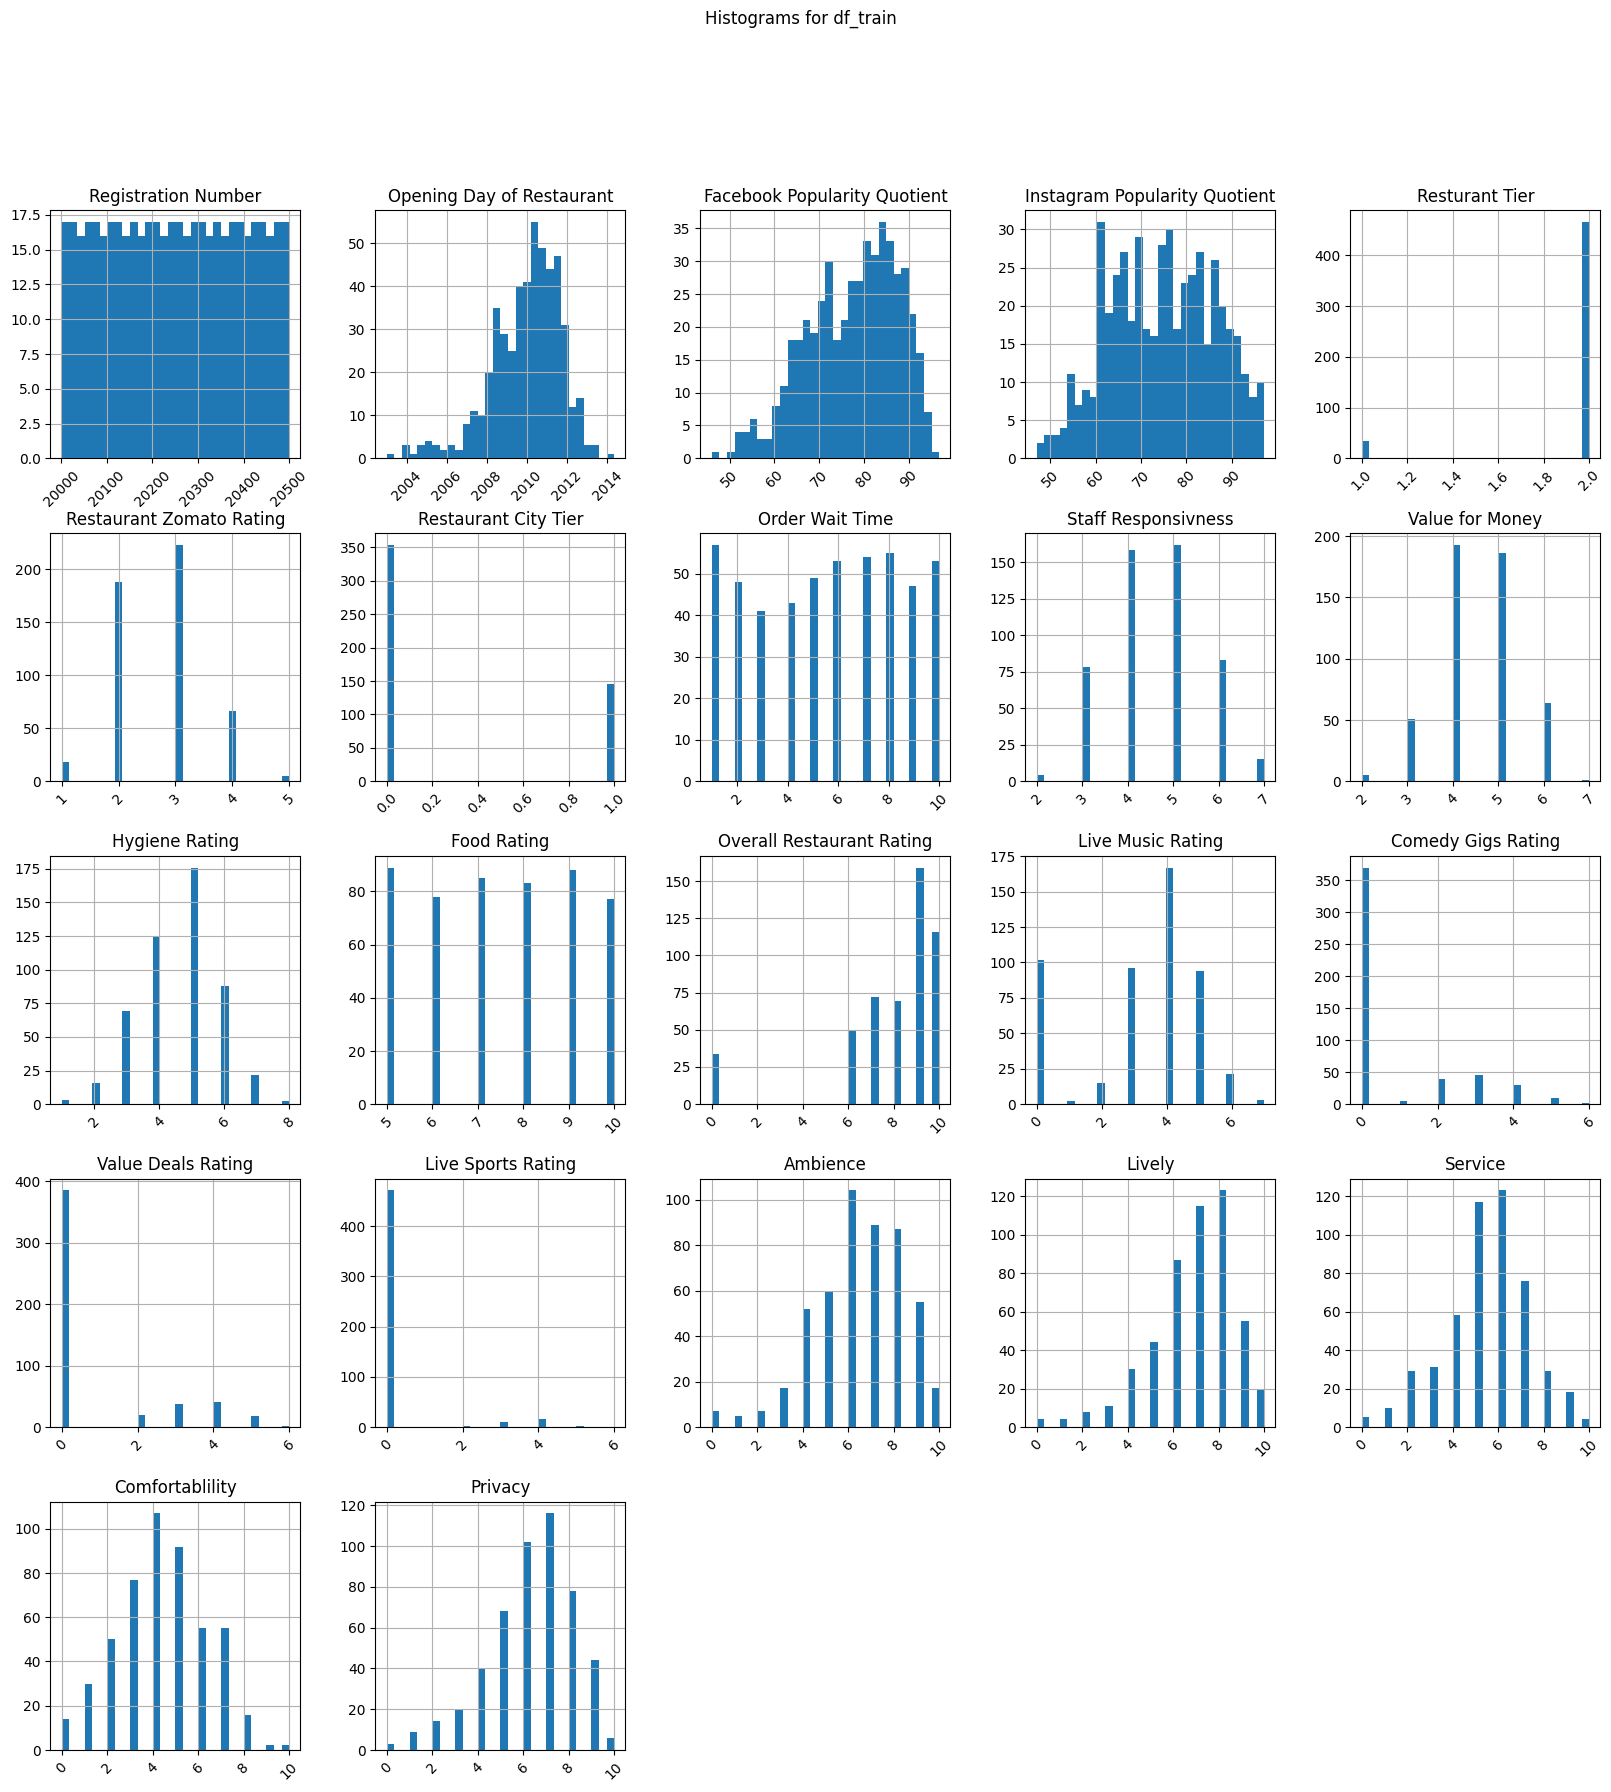

In [237]:
axes = df_test.hist(bins=30, figsize=(20, 20))
plt.suptitle('Histograms for df_train')
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

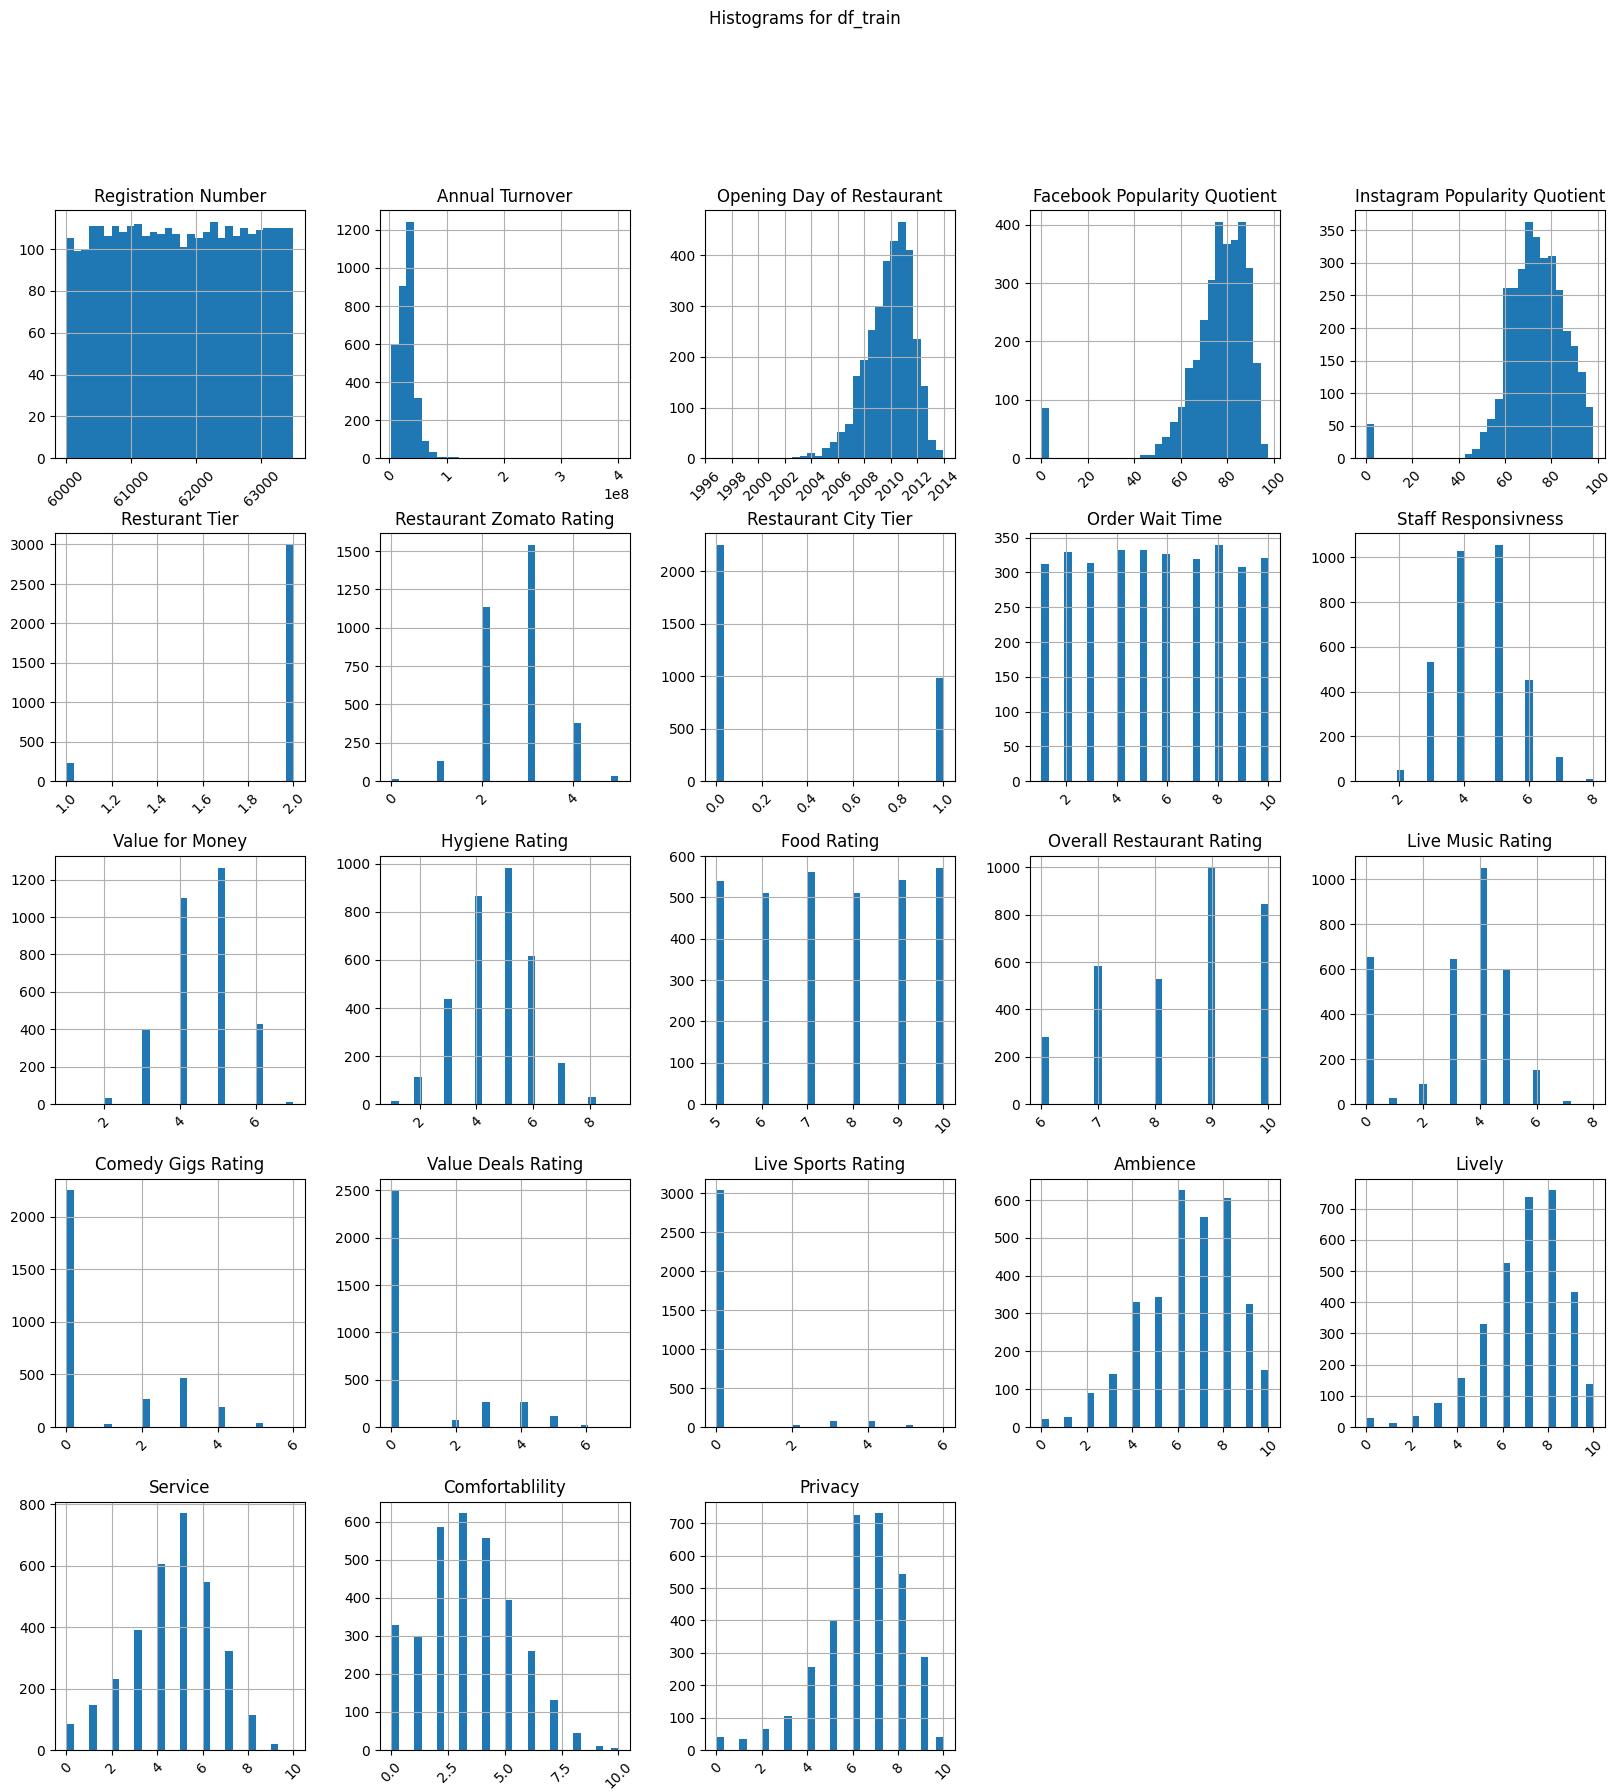

In [238]:
axes = df_train.hist(bins=30, figsize=(20, 20))
plt.suptitle('Histograms for df_train')
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

- Note:

I commented the code below since the graphs mostly show the same information, left it for future reference.

In [239]:
def create_density_plots(df, title):
    '''
    Function to create density plots for all numerical columns in a DataFrame.
    '''
    num_columns = df.select_dtypes(include=['number']).columns
    num_plots = len(num_columns)
    num_rows = (num_plots + 2) // 3  # Adjust the number of columns per row as needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
    fig.suptitle(title, fontsize=16)
    
    for i, col in enumerate(num_columns):
        ax = axes.flatten()[i]
        sns.kdeplot(df[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Density')
    
    # Remove empty subplots
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()


In [240]:
# Create density plots for df_train
#create_density_plots(df_train, 'Density Plots for df_train')

In [241]:
#create_density_plots(df_test, 'Density Plots for df_test')

In [242]:
# Function to create boxplots for a DataFrame
def create_boxplots(df, title):
    num_columns = df.select_dtypes(include=['number']).columns
    num_plots = len(num_columns)
    num_rows = (num_plots + 2) // 3  # Adjust the number of columns per row as needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
    fig.suptitle(title, fontsize=16)
    
    for i, col in enumerate(num_columns):
        ax = axes.flatten()[i]
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Value')
    
    # Remove empty subplots
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

In [243]:
# Create boxplots for df_train
#create_boxplots(df_train, 'Boxplots for df_train')

In [244]:
# Create boxplots for df_test
#create_boxplots(df_test, 'Boxplots for df_test')

### b) Distribution of Categorical Features

Bar plots and count plots

In [245]:
# Function to create bar plots for a DataFrame
def create_bar_plots(df, title):
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    num_plots = len(cat_columns)
    num_rows = (num_plots + 2) // 3  # Adjust the number of columns per row as needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    fig.suptitle(title, fontsize=16)
    
    for i, col in enumerate(cat_columns):
        ax = axes.flatten()[i]
        sns.countplot(y=df[col], ax=ax, order= df[col].value_counts().index)  # Use y=df[col] for horizontal bar plots
        ax.set_title(col)
        ax.set_xlabel('Count')
        ax.set_ylabel('')
    
    # Remove empty subplots
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

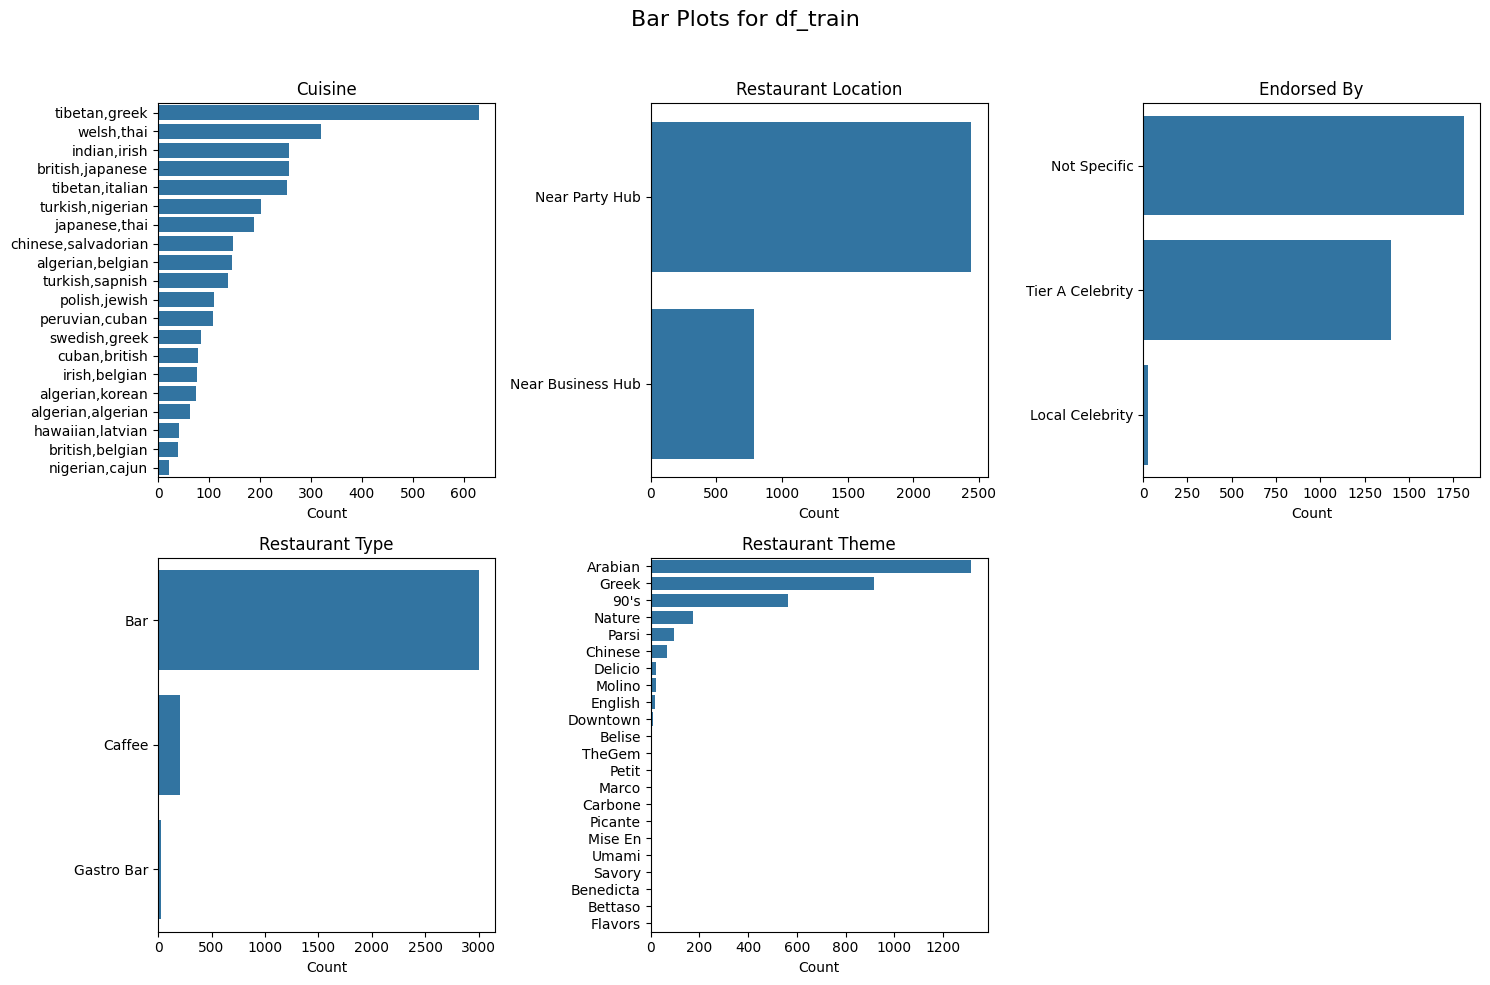

In [246]:
# Drop city because it is too clutered
create_bar_plots(df_train.drop(columns={'City'}), 'Bar Plots for df_train')

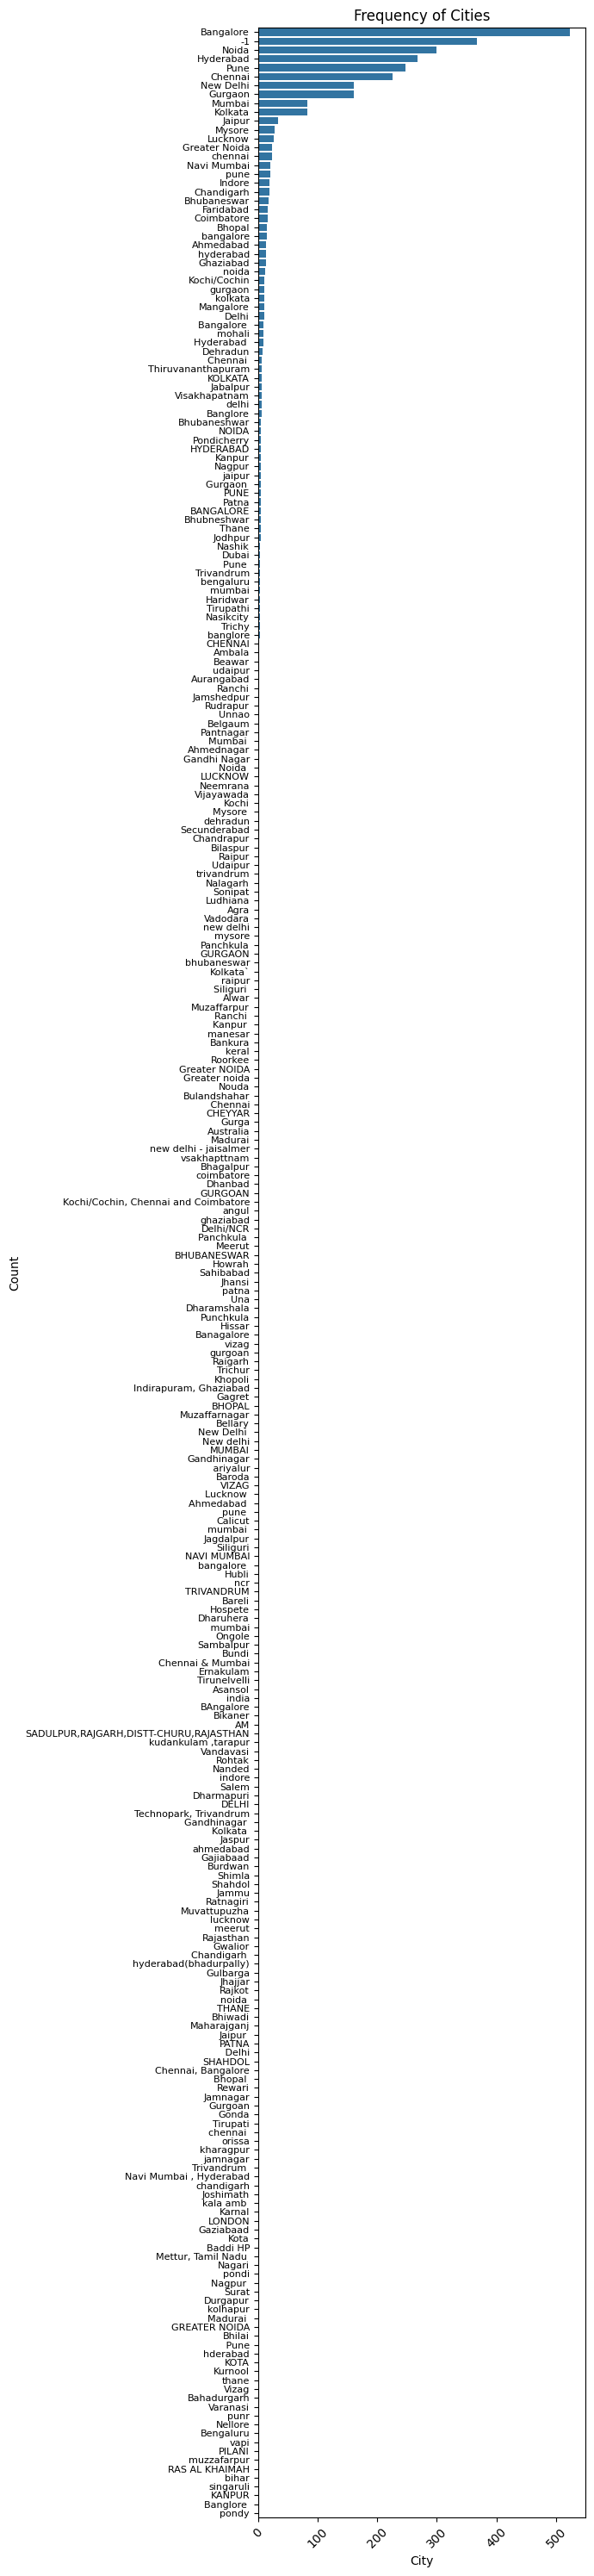

In [247]:
plt.figure(figsize=(7, 30))
sns.countplot(y='City', data=df_train, order = df_train['City'].value_counts().index)
plt.title('Frequency of Cities')
plt.xlabel('City')
plt.ylabel('Count')
plt.yticks(fontsize=8)  # Adjust font size of y-axis labels
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

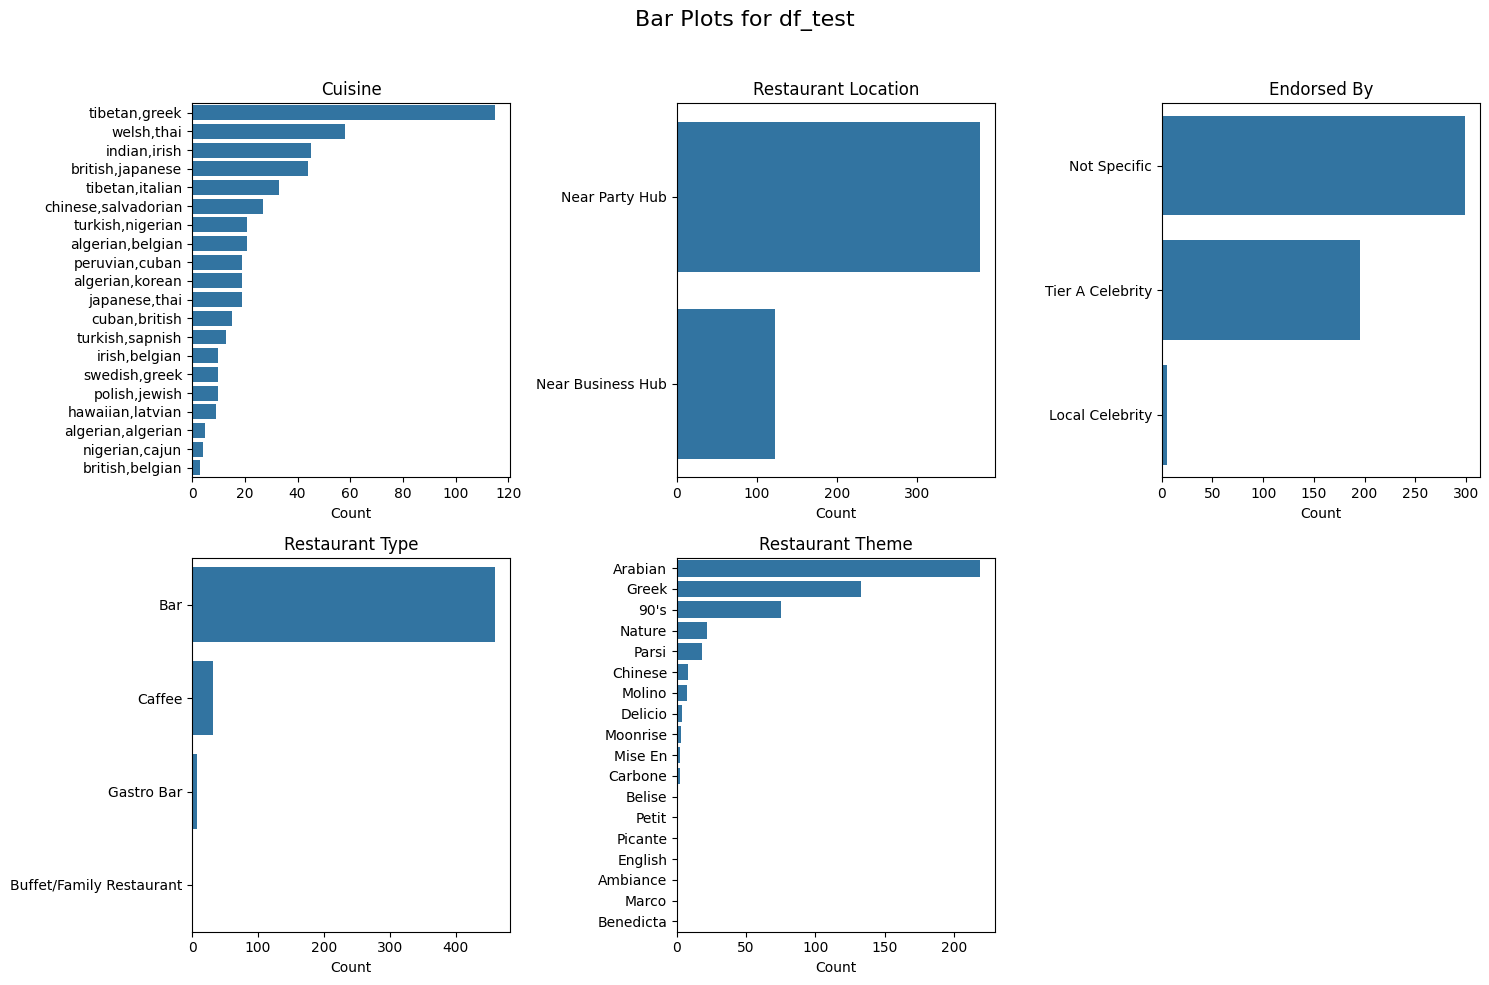

In [248]:
# Drop city because it is too clutered
create_bar_plots(df_test.drop(columns={'City'}), 'Bar Plots for df_test')

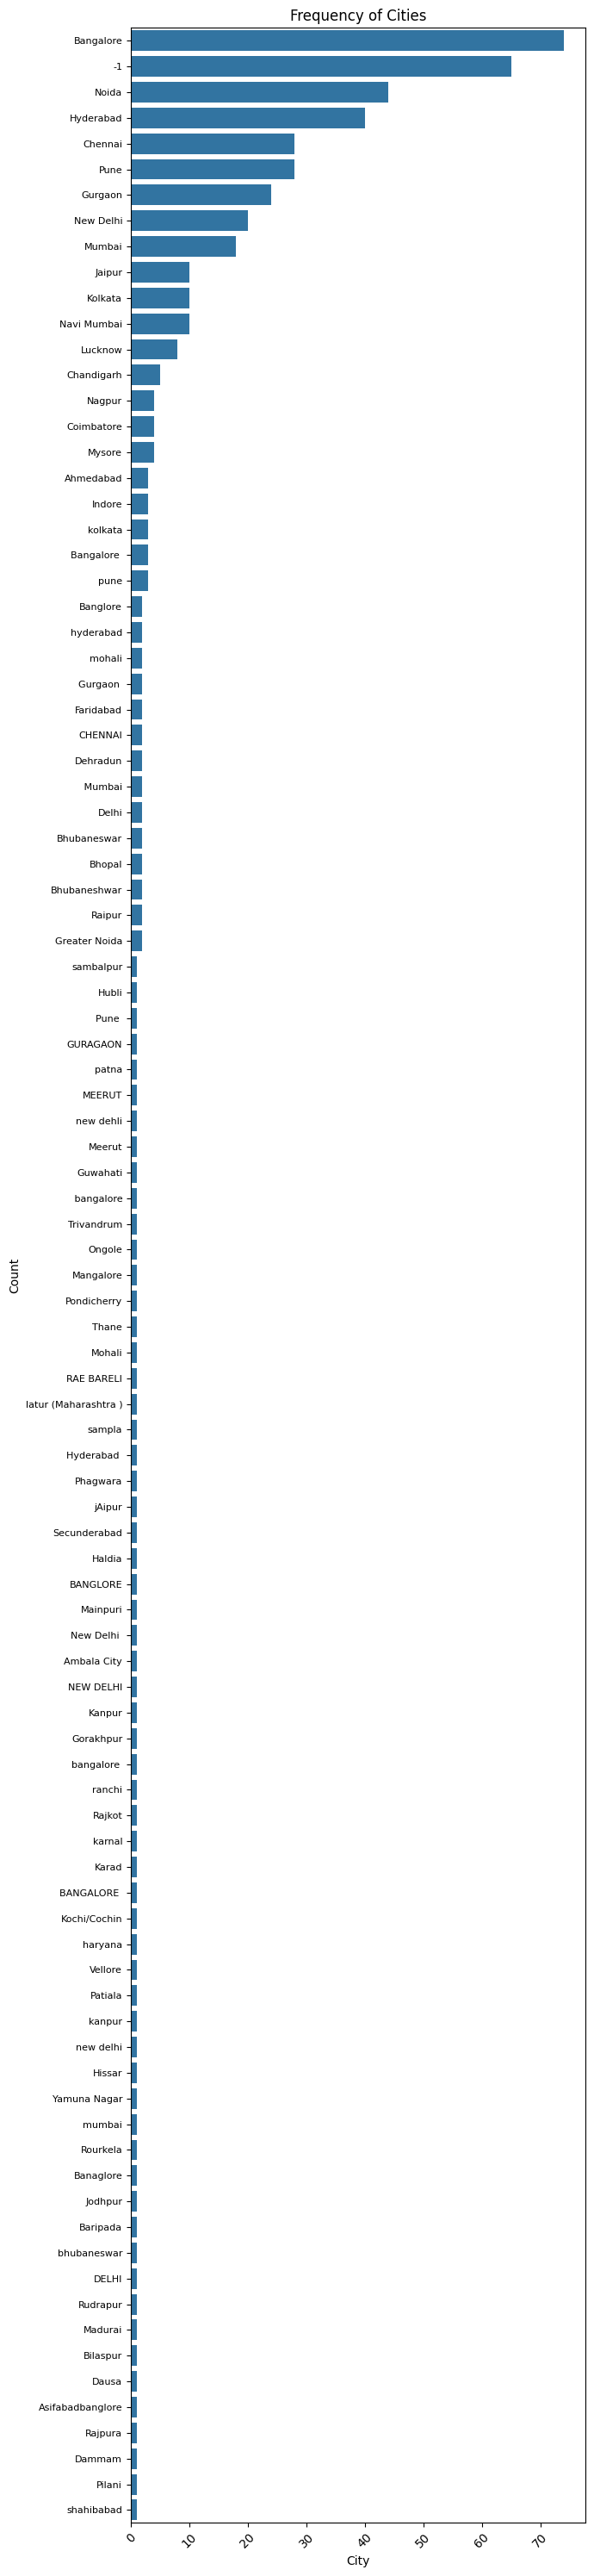

In [249]:
plt.figure(figsize=(7, 30))
sns.countplot(y='City', data=df_test, order = df_test['City'].value_counts().index)
plt.title('Frequency of Cities')
plt.xlabel('City')
plt.ylabel('Count')
plt.yticks(fontsize=8)  # Adjust font size of y-axis labels
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

- Note:

Many cities are repeated and the naming must be standarized. Beggining with removing any trailing and leading spaces, as well as lowercasing the entire column.

#### Cleaning City

Since naming is not consistent and there is the inclusion of a variable _-1_, naming must be fixed and the variable will be taken as _other_ and an indicator column will be added to identify as such.

In [250]:
df_test['City'].unique()

array(['Bangalore', 'Hyderabad', '-1', 'Pune ', 'New Delhi', 'MEERUT',
       'Chennai', 'Lucknow', 'Gurgaon', 'Navi Mumbai', 'GURAGAON',
       'Ahmedabad', 'Nagpur', 'Mumbai', 'Coimbatore', 'patna', 'Noida',
       'Bangalore ', 'kolkata', 'Pune', 'Hubli', 'Guwahati', 'Mysore',
       'hyderabad', 'Jaipur', 'mohali', 'Meerut', 'Banglore', 'new dehli',
       'Kolkata', 'sambalpur', 'Chandigarh', 'Indore', 'Bhubaneswar',
       'NEW DELHI', 'Ambala City', ' Mumbai', 'New Delhi ', 'Gurgaon ',
       'Trivandrum', 'Delhi', 'Ongole', 'Mangalore', 'Mohali',
       ' bangalore', 'Dehradun', 'Thane', 'CHENNAI', 'Pondicherry',
       'RAE BARELI', 'Faridabad', 'Hyderabad ', 'Phagwara',
       'latur (Maharashtra )', 'sampla', 'Secunderabad', 'jAipur', 'pune',
       'BANGLORE', 'Haldia', 'Mainpuri', 'bangalore ', 'Gorakhpur',
       'Kanpur', 'Bhopal', 'BANGALORE ', 'ranchi', 'Greater Noida',
       'Rajkot', 'karnal', 'Bhubaneshwar', 'Karad', 'Kochi/Cochin',
       'haryana', 'Raipur', 'Vel

In [251]:
def remove_trail_lead_lower(col):
    '''
    Remove leading and trailing whitespaces and convert to lowercase.
    '''
    df_train[col] = df_train[col].str.strip().str.lower()
    df_test[col] = df_test[col].str.strip().str.lower()

In [252]:
remove_trail_lead_lower('City')

In [253]:
# order by alphabetical order

sorted(df_test['City'].unique())

['-1',
 'ahmedabad',
 'ambala city',
 'asifabadbanglore',
 'banaglore',
 'bangalore',
 'banglore',
 'baripada',
 'bhopal',
 'bhubaneshwar',
 'bhubaneswar',
 'bilaspur',
 'chandigarh',
 'chennai',
 'coimbatore',
 'dammam',
 'dausa',
 'dehradun',
 'delhi',
 'faridabad',
 'gorakhpur',
 'greater noida',
 'guragaon',
 'gurgaon',
 'guwahati',
 'haldia',
 'haryana',
 'hissar',
 'hubli',
 'hyderabad',
 'indore',
 'jaipur',
 'jodhpur',
 'kanpur',
 'karad',
 'karnal',
 'kochi/cochin',
 'kolkata',
 'latur (maharashtra )',
 'lucknow',
 'madurai',
 'mainpuri',
 'mangalore',
 'meerut',
 'mohali',
 'mumbai',
 'mysore',
 'nagpur',
 'navi mumbai',
 'new dehli',
 'new delhi',
 'noida',
 'ongole',
 'patiala',
 'patna',
 'phagwara',
 'pilani',
 'pondicherry',
 'pune',
 'rae bareli',
 'raipur',
 'rajkot',
 'rajpura',
 'ranchi',
 'rourkela',
 'rudrapur',
 'sambalpur',
 'sampla',
 'secunderabad',
 'shahibabad',
 'thane',
 'trivandrum',
 'vellore',
 'yamuna nagar']

In [254]:
df_test['City'].nunique()

74

- Note:

After removing the capitalization and using strip to remove leading and trailing spaces the remaining incorrect city names in df_test are:

    asifabadbanglore -> bangalore
    banaglore -> bangalore
    banglore -> bangalore
    bhubaneshwar -> bhubaneswar
    kochi/cochin -> kochi
    latur (maharashtra ) -> latur
    new dehli -> new delhi

df_train is a much larger dataset and will also need to be checked for inconsistencies.

In [255]:
city_mapping = {
    'asifabadbanglore': 'bangalore',
    'banaglore': 'bangalore',
    'banglore': 'bangalore',
    'bhubaneshwar': 'bhubaneswar',
    'kochi/cochin': 'kochi',
    'latur (maharashtra )': 'latur',
    'new dehli': 'new delhi'
}


In [256]:
df_test['City'] = df_test['City'].replace(city_mapping)
df_train['City'] = df_train['City'].replace(city_mapping)

In [257]:
df_test['City'].nunique()

69

In [258]:
df_train['City'].nunique()

188

In [259]:
sorted(df_train['City'].unique())

['-1',
 'agra',
 'ahmedabad',
 'ahmednagar',
 'alwar',
 'am',
 'ambala',
 'angul',
 'ariyalur',
 'asansol',
 'aurangabad',
 'australia',
 'baddi hp',
 'bahadurgarh',
 'banagalore',
 'bangalore',
 'bankura',
 'bareli',
 'baroda',
 'beawar',
 'belgaum',
 'bellary',
 'bengaluru',
 'bhagalpur',
 'bhilai',
 'bhiwadi',
 'bhopal',
 'bhubaneswar',
 'bhubneshwar',
 'bihar',
 'bikaner',
 'bilaspur',
 'bulandshahar',
 'bundi',
 'burdwan',
 'calicut',
 'chandigarh',
 'chandrapur',
 'chennai',
 'chennai & mumbai',
 'chennai, bangalore',
 'cheyyar',
 'coimbatore',
 'dehradun',
 'delhi',
 'delhi/ncr',
 'dhanbad',
 'dharamshala',
 'dharmapuri',
 'dharuhera',
 'dubai',
 'durgapur',
 'ernakulam',
 'faridabad',
 'gagret',
 'gajiabaad',
 'gandhi nagar',
 'gandhinagar',
 'gaziabaad',
 'ghaziabad',
 'gonda',
 'greater noida',
 'gulbarga',
 'gurga',
 'gurgaon',
 'gurgoan',
 'gwalior',
 'haridwar',
 'hderabad',
 'hissar',
 'hospete',
 'howrah',
 'hubli',
 'hyderabad',
 'hyderabad(bhadurpally)',
 'india',
 'in

In [260]:
city_mapping = {
    'banagalore': 'bangalore',
    'bengaluru': 'bangalore',
    'bhubneshwar': 'bhubaneswar',
    'chennai & mumbai': 'chennai',
    'chennai, bangalore': 'chennai',
    'delhi/ncr': 'delhi',
    'gajiabaad': 'ghaziabad',
    'gandhi nagar': 'gandhinagar',
    'gaziabaad': 'ghaziabad',
    'gurga': 'gurgaon',
    'gurgoan': 'gurgaon',
    'hderabad': 'hyderabad',
    'hyderabad(bhadurpally)': 'hyderabad',
    'indirapuram, ghaziabad': 'ghaziabad',
    'kochi/cochin, chennai and coimbatore': 'kochi',
    'kolkata`': 'kolkata',
    'kudankulam ,tarapur': 'kudankulam',
    'mettur, tamil nadu': 'mettur',
    'muzzafarpur': 'muzaffarpur',
    'nasikcity': 'nashik',
    'navi mumbai , hyderabad': 'navi mumbai',
    'new delhi - jaisalmer': 'new delhi',
    'nouda': 'noida',
    'pondy': 'pondicherry',
    'punr': 'pune',
    'sadulpur,rajgarh,distt-churu,rajasthan': 'sadulpur',
    'technopark, trivandrum': 'trivandrum',
    'tirunelvelli': 'tirunelveli',
    'vsakhapttnam': 'visakhapatnam',
    'vizag': 'visakhapatnam'
}

In [261]:
df_test['City'] = df_test['City'].replace(city_mapping)
df_train['City'] = df_train['City'].replace(city_mapping)

In [262]:
df_train['City'].nunique()

162

- Note:

Many of the city values are recorded as _-1_, this will be taken as missing city information and an indicator column will be added.

In [263]:
# Add an indicator column for missing city information
df_train['City_Missing'] = df_train['City'] == '-1'
df_test['City_Missing'] = df_test['City'] == '-1'

- Note:

The Value _-1_ will be kept as a placeholder for missing values but also asuming it could be a use of _others_ in context of the cities I won't be filling the values with the mean value as I would like to keep the data as intact as possible.

Also considering the data includes only 91 cities excluding _-1_ and India has approximatley 4,000 cities and towns, filling in the data with mean values does not seem like the correct decision.

## 3. Bivariate Analysis
- Numerical vs Numerical: Use scatter plots and pair plots.
- Numerical vs Categorical: Use box plots and violin plots.
- Categorical vs Categorical: Use cross-tabulations and heatmaps.

### a) Numerical vs Numerical

- Note: 

Starting with a correlation matrix to identify pairs of variables with strong relationships in order to identify which should be plotted. 

Since the larger dataset is df_train these steps will only be done with that data

In [264]:
df_train.dtypes

Registration Number                       int64
Annual Turnover                           int64
Cuisine                                  object
City                                     object
Restaurant Location                      object
Opening Day of Restaurant        datetime64[ns]
Facebook Popularity Quotient            float64
Endorsed By                              object
Instagram Popularity Quotient           float64
Fire Audit                                 bool
Liquor License Obtained                    bool
Situated in a Multi Complex                bool
Dedicated Parking                          bool
Open Sitting Available                     bool
Resturant Tier                          float64
Restaurant Type                          object
Restaurant Theme                         object
Restaurant Zomato Rating                  int64
Restaurant City Tier                      int64
Order Wait Time                           int64
Staff Responsivness                     

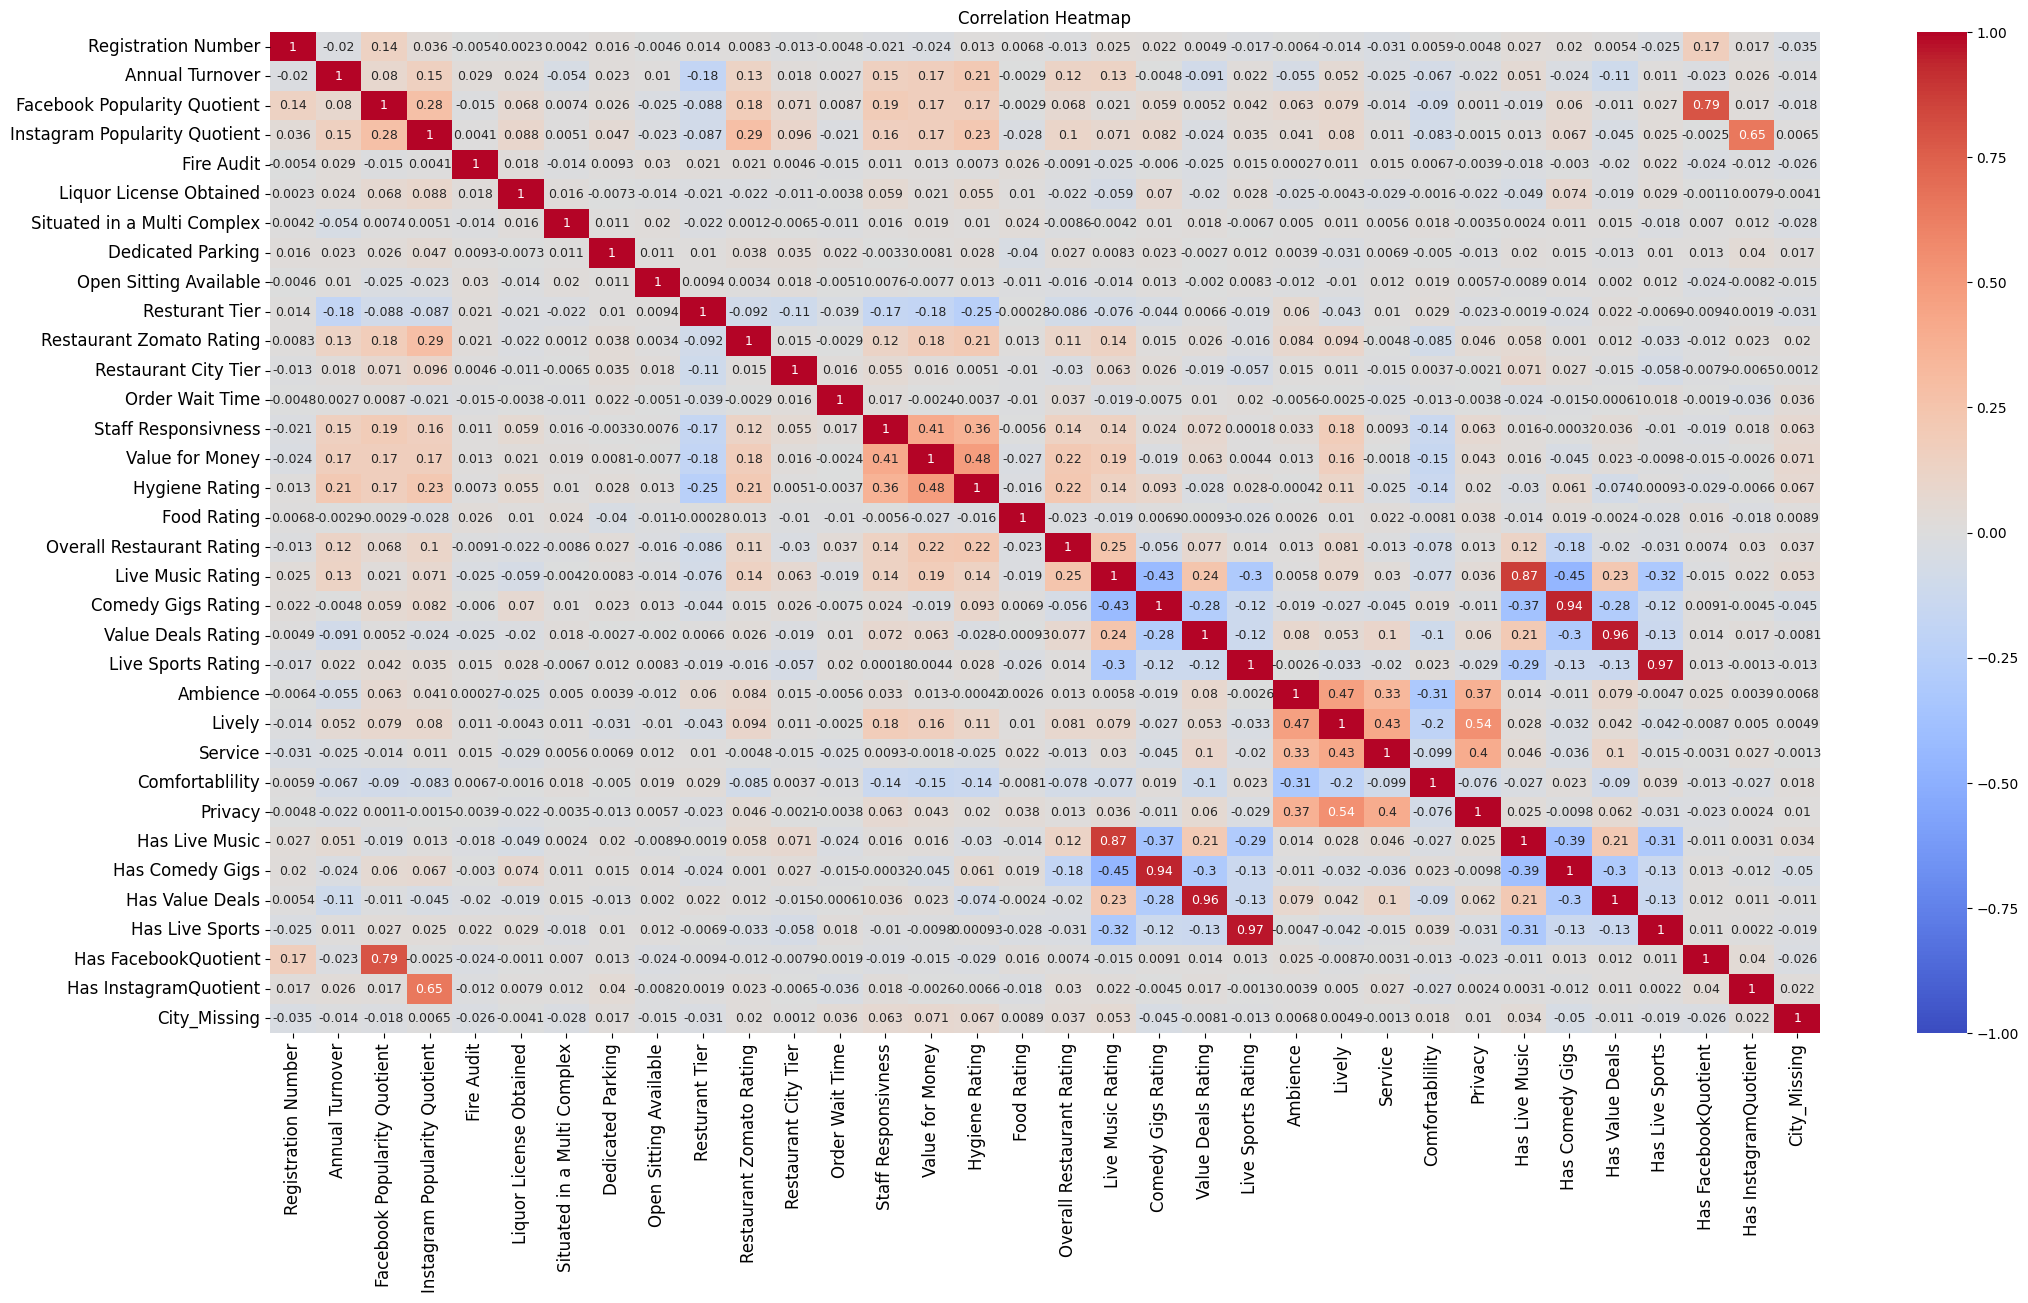

In [265]:
# Correlation Matrix
numerical_df = df_train.select_dtypes(include=['number','bool'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(25, 13))
sns.heatmap(correlation_matrix, annot=True,annot_kws={'size': 9}, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [266]:
correlation_df = correlation_matrix.stack().reset_index()
correlation_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Add a new column 'Positive' to indicate if the original correlation is positive or not
original_correlations = correlation_matrix.stack().reset_index()
correlation_df['Positive'] = np.where(original_correlations[0] > 0, True, False)

correlation_df = correlation_df[correlation_df['Correlation'] != 1]

# Convert correlation values to absolute values using .loc to avoid SettingWithCopyWarning
correlation_df.loc[:, 'Correlation'] = correlation_df['Correlation'].abs()

# Sort variable names to ensure each pair is only represented once
correlation_df['Pair'] = correlation_df.apply(lambda row: tuple(sorted([row['Variable 1'], row['Variable 2']])), axis=1)

# Drop duplicate pairs
correlation_df = correlation_df.drop_duplicates(subset='Pair').drop(columns='Pair')

# Sort by correlation value
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

In [267]:
annual_turnover_correlation = correlation_df[correlation_df['Variable 1'] == 'Annual Turnover'].sort_values(by='Correlation', ascending=False)
annual_turnover_correlation

,Variable 1,Variable 2,Correlation,Positive
49,Annual Turnover,Hygiene Rating,0.213081,True
43,Annual Turnover,Resturant Tier,0.184495,False
48,Annual Turnover,Value for Money,0.167819,True
47,Annual Turnover,Staff Responsivness,0.153366,True
37,Annual Turnover,Instagram Popularity Quotient,0.150887,True
44,Annual Turnover,Restaurant Zomato Rating,0.129577,True
52,Annual Turnover,Live Music Rating,0.127646,True
51,Annual Turnover,Overall Restaurant Rating,0.119214,True
63,Annual Turnover,Has Value Deals,0.109025,False
54,Annual Turnover,Value Deals Rating,0.090900,False


In [268]:
# Identify highly correlated variables (e.g., |correlation| > 0.5)
highly_correlated_vars = correlation_matrix.index[correlation_matrix['Annual Turnover'].abs() > 0.10].tolist()
highly_correlated_vars.remove('Annual Turnover')

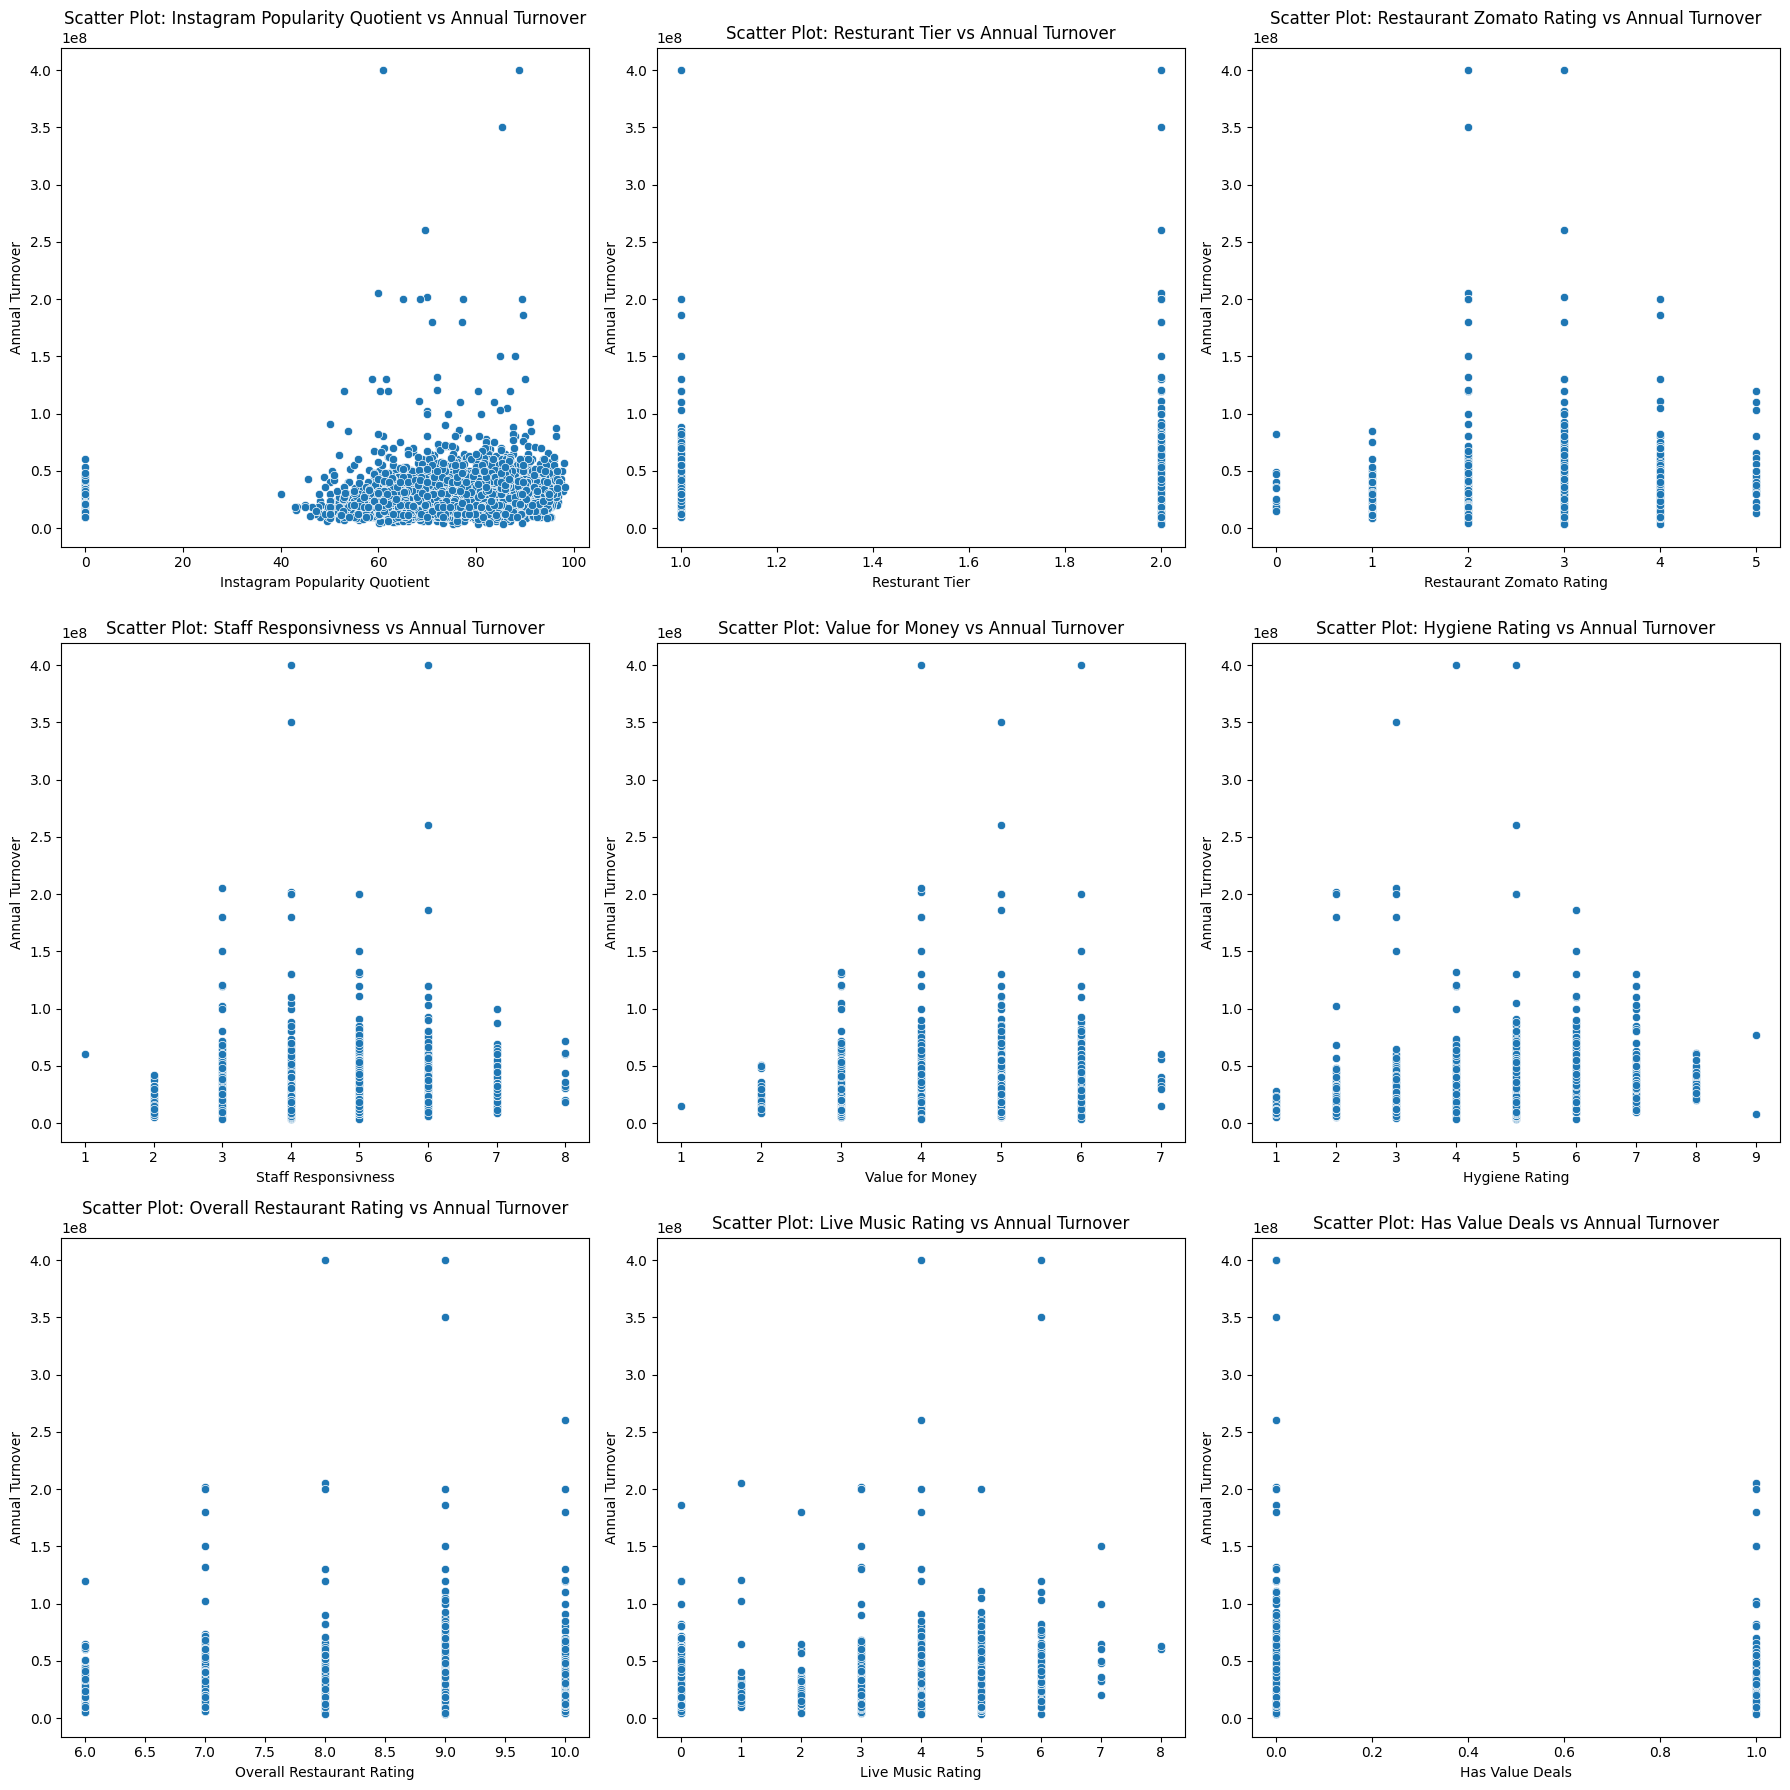

In [269]:
# Set up the subplot grid
num_vars = len(highly_correlated_vars)
cols = 3  # Number of columns in the grid
rows = (num_vars // cols) + (num_vars % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

# Create scatter plots for each variable
for i, var in enumerate(highly_correlated_vars):
    sns.scatterplot(ax=axes[i], x=var, y='Annual Turnover', data=df_train)
    axes[i].set_title(f'Scatter Plot: {var} vs Annual Turnover')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Annual Turnover')

# Remove unused subplots if the grid has empty spaces
for j in range(len(highly_correlated_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Note:

Investigate exploring multivariate techniques like regression analysis or feature importance from a machine learning model to better understand the combined impact of these variables. (For future refrence)

- Interpretation of Results:

[Click here to open Interpretation Document](./Indepth%20Results\ANOVA%20Interpretation.docx)

__Significant Factors:__

Hygine Rating, Social Media Popularity (Instagram and Facebook), Value for Money, Live Music Rating, Zomato Ratings.


### b) Numerical vs Categorical

- Note:

The primary focus for the bivariate analysis is the Annual Turnover in comparison to the categorical values.

The secondary focus is to focus on exploring the relationship of the categorical values vs all numerical values or at least the highly correlated ones to Annual Turnover. Due to lack of time this will not be done

In [270]:
# show categorical columns
object_columns = df_train.select_dtypes(include=['object']).columns.to_list()
object_columns.remove('City')

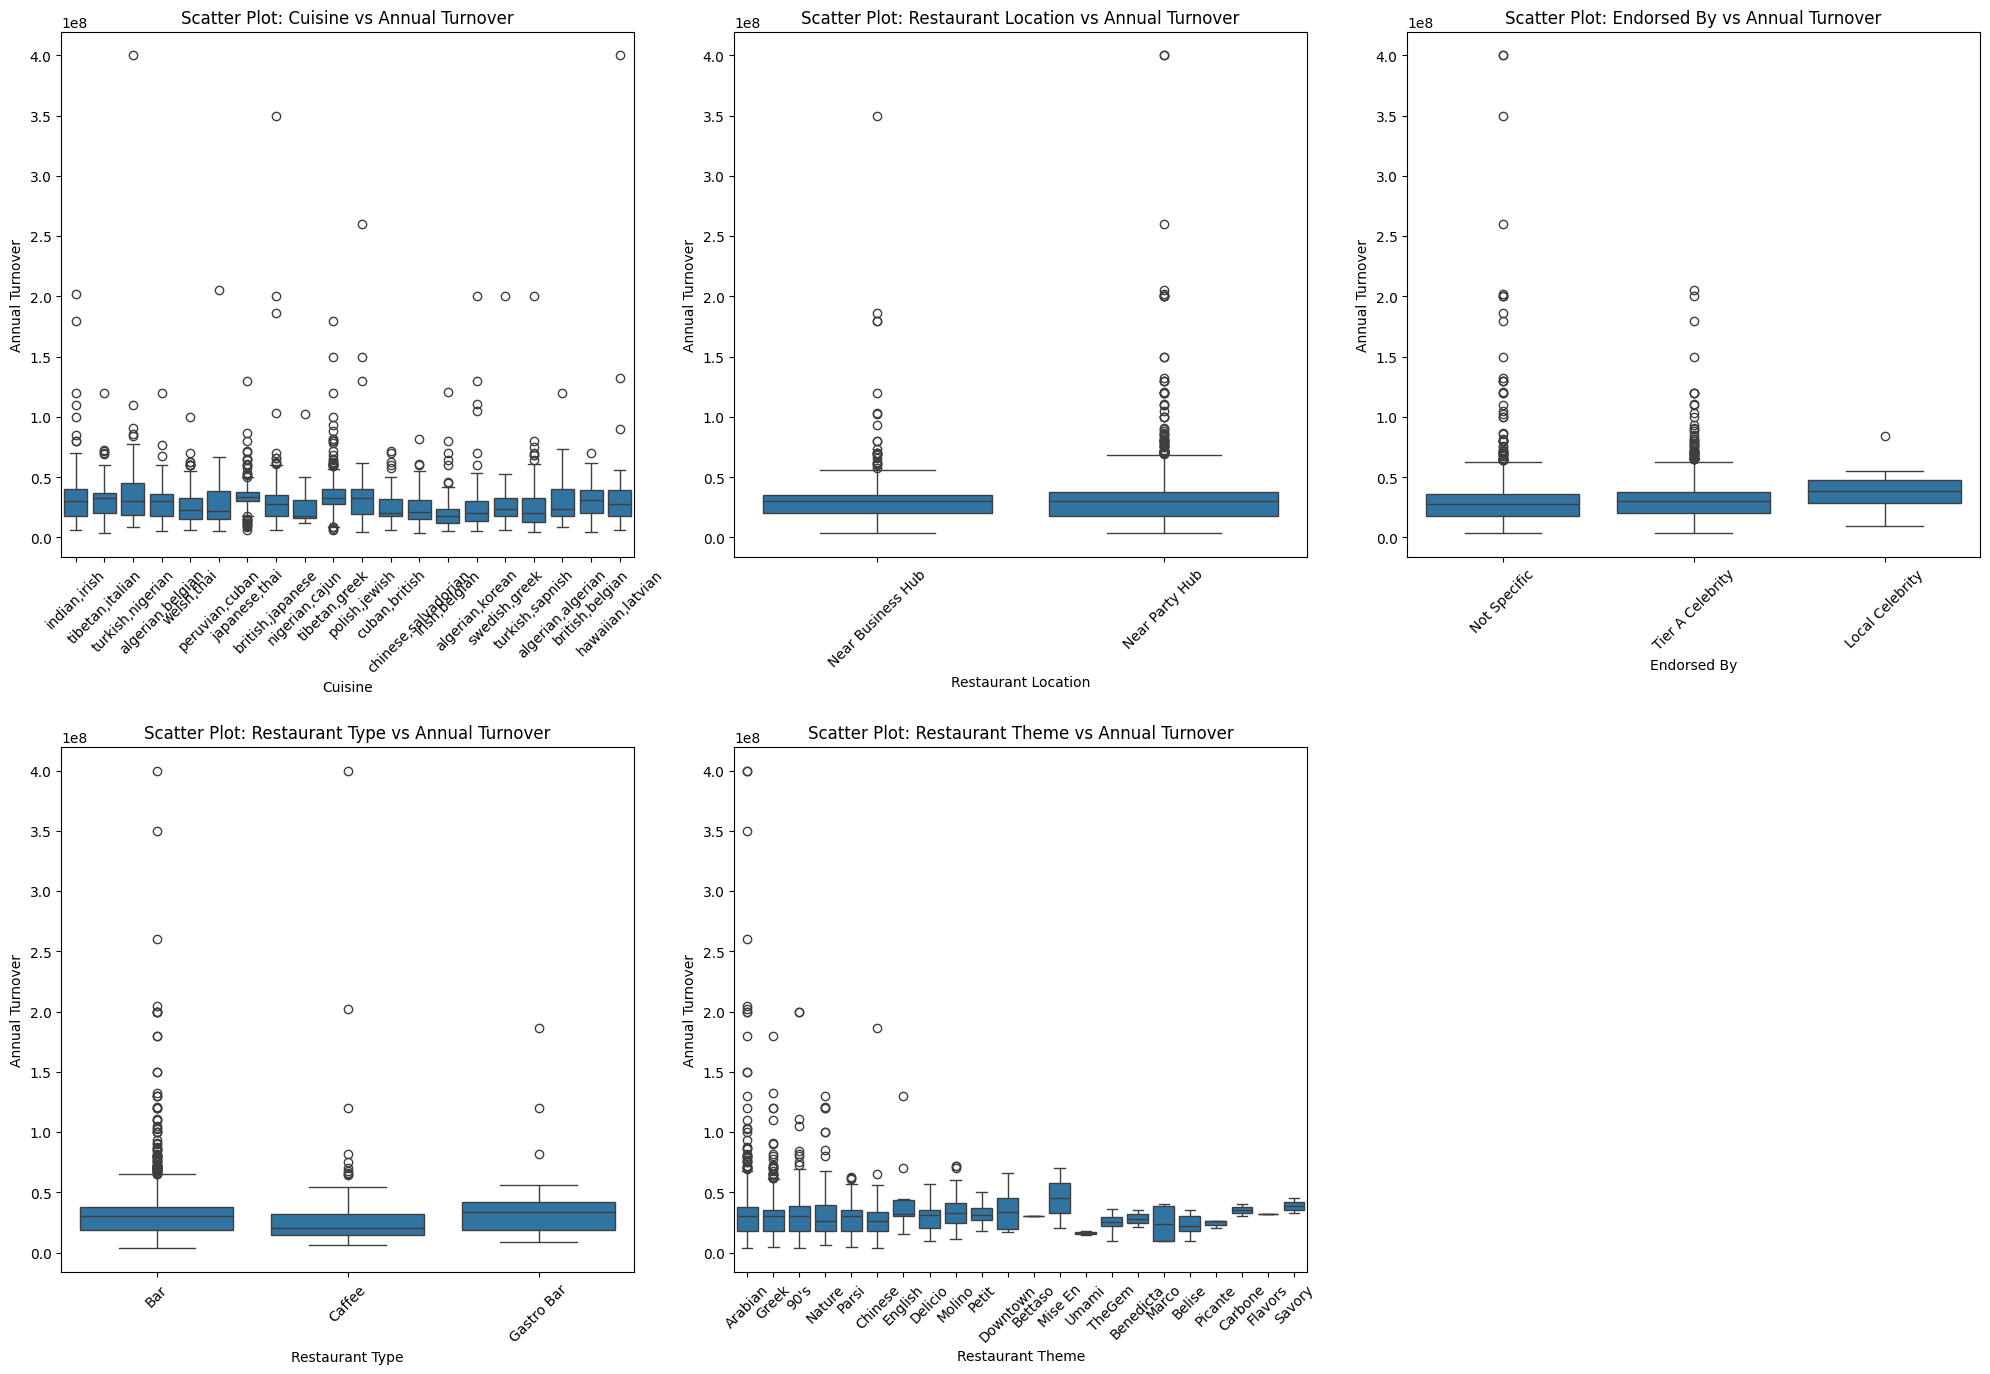

In [271]:
# Set up the subplot grid
num_vars = len(object_columns)
cols = 3  # Number of columns in the grid
rows = (num_vars // cols) + (num_vars % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 7))
axes = axes.flatten()

# Create scatter plots for each variable
for i, var in enumerate(object_columns):
    sns.boxplot(ax=axes[i], x=var, y='Annual Turnover', data=df_train)
    axes[i].set_title(f'Scatter Plot: {var} vs Annual Turnover')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Annual Turnover')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots if the grid has empty spaces
for j in range(len(object_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

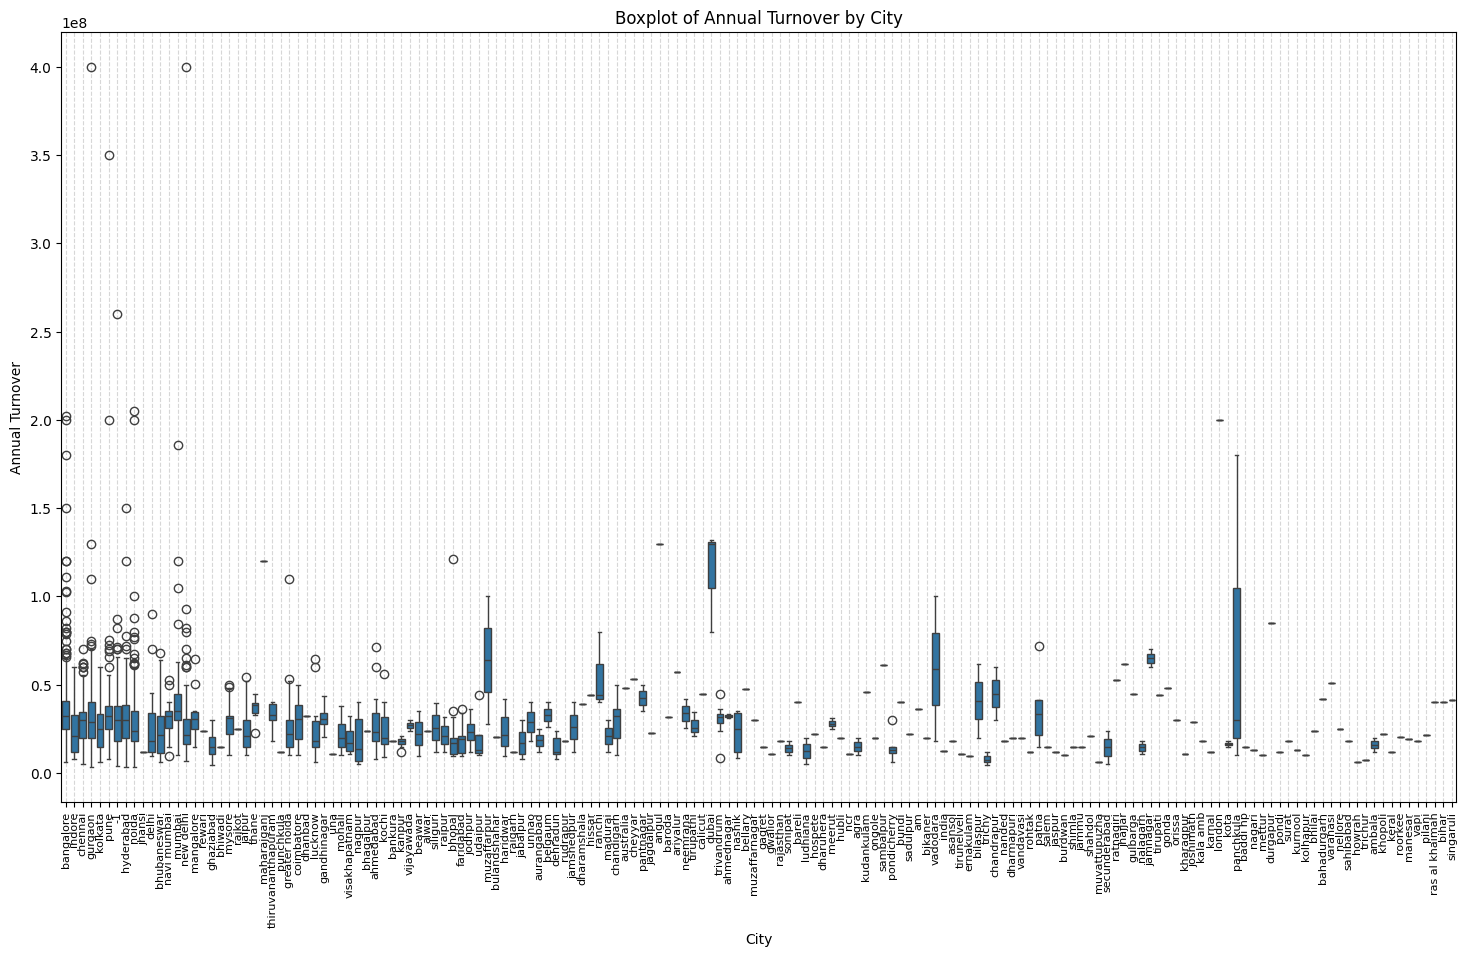

In [272]:
# sns boxplot for city
plt.figure(figsize=(18, 10))
sns.boxplot(x='City', y='Annual Turnover', data=df_train)
plt.title('Boxplot of Annual Turnover by City')
plt.xlabel('City')
plt.ylabel('Annual Turnover')
plt.xticks(rotation=90)
plt.xticks(size=8)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

In [273]:
# Anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Redefine the object columns (City was removed previously)
object_columns = df_train.select_dtypes(include=['object']).columns.to_list()

# Perform ANOVA for each categorical variable
anova_results = {}

# Perform ANOVA for each object column
for var in object_columns:
    model = ols(f'Q("Annual Turnover") ~ C(Q("{var}"))', data=df_train).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[var] = anova_table

# Display ANOVA results
for var, result in anova_results.items():
    print(f'ANOVA results for {var}:')
    print(result)
    print('\n')

ANOVA results for Cuisine:
                       sum_sq      df         F        PR(>F)
C(Q("Cuisine"))  4.705459e+16    19.0  5.606894  6.376716e-14
Residual         1.419619e+18  3214.0       NaN           NaN


ANOVA results for City:
                    sum_sq      df         F        PR(>F)
C(Q("City"))  1.655696e+17   161.0  2.428084  2.039344e-19
Residual      1.301104e+18  3072.0       NaN           NaN


ANOVA results for Restaurant Location:
                                   sum_sq      df         F   PR(>F)
C(Q("Restaurant Location"))  1.183523e+15     1.0  2.610147  0.10628
Residual                     1.465491e+18  3232.0       NaN      NaN


ANOVA results for Endorsed By:
                           sum_sq      df         F    PR(>F)
C(Q("Endorsed By"))  2.956404e+15     2.0  3.262973  0.038401
Residual             1.463718e+18  3231.0       NaN       NaN


ANOVA results for Restaurant Type:
                               sum_sq      df         F    PR(>F)
C(Q("Restauran

- Note:

Guide Interpretation of Results

__F-statistic:__ The F-statistic measures the ratio of the variance between the groups to the variance within the groups. A higher F-statistic indicates a greater difference between the group means.

__p-value:__ The p-value indicates the probability that the observed differences between the group means occurred by chance. A p-value less than 0.05 (commonly used threshold) suggests that the differences are statistically significant.

- Interpretation of Results:

[Click here to open Interpretation Document](./Indepth%20Results\ANOVA%20Interpretation.docx)

__Significant Factors:__

__City, Endorsed By, and Restaurant Type__ are significant factors that impact the dependent variable.
These variables should be explored further to understand their specific contributions.

__Not Significant:__

Restaurant Location and Restaurant Theme do not significantly impact the dependent variable and may not warrant further detailed analysis unless there are theoretical reasons to consider them.

### c) Categorical vs Categorical

## 4. Multivariate Analysis
- Pair Plots: Visualize relationships between multiple numerical features.
- Heatmaps: Visualize correlations between multiple features.

## 5. Outlier Detection
- Box Plots: Identify outliers in numerical features.
- Z-Score or IQR: Use statistical methods to detect outliers.

#### Outliers for df_train

In [274]:
df_test.shape

(500, 40)

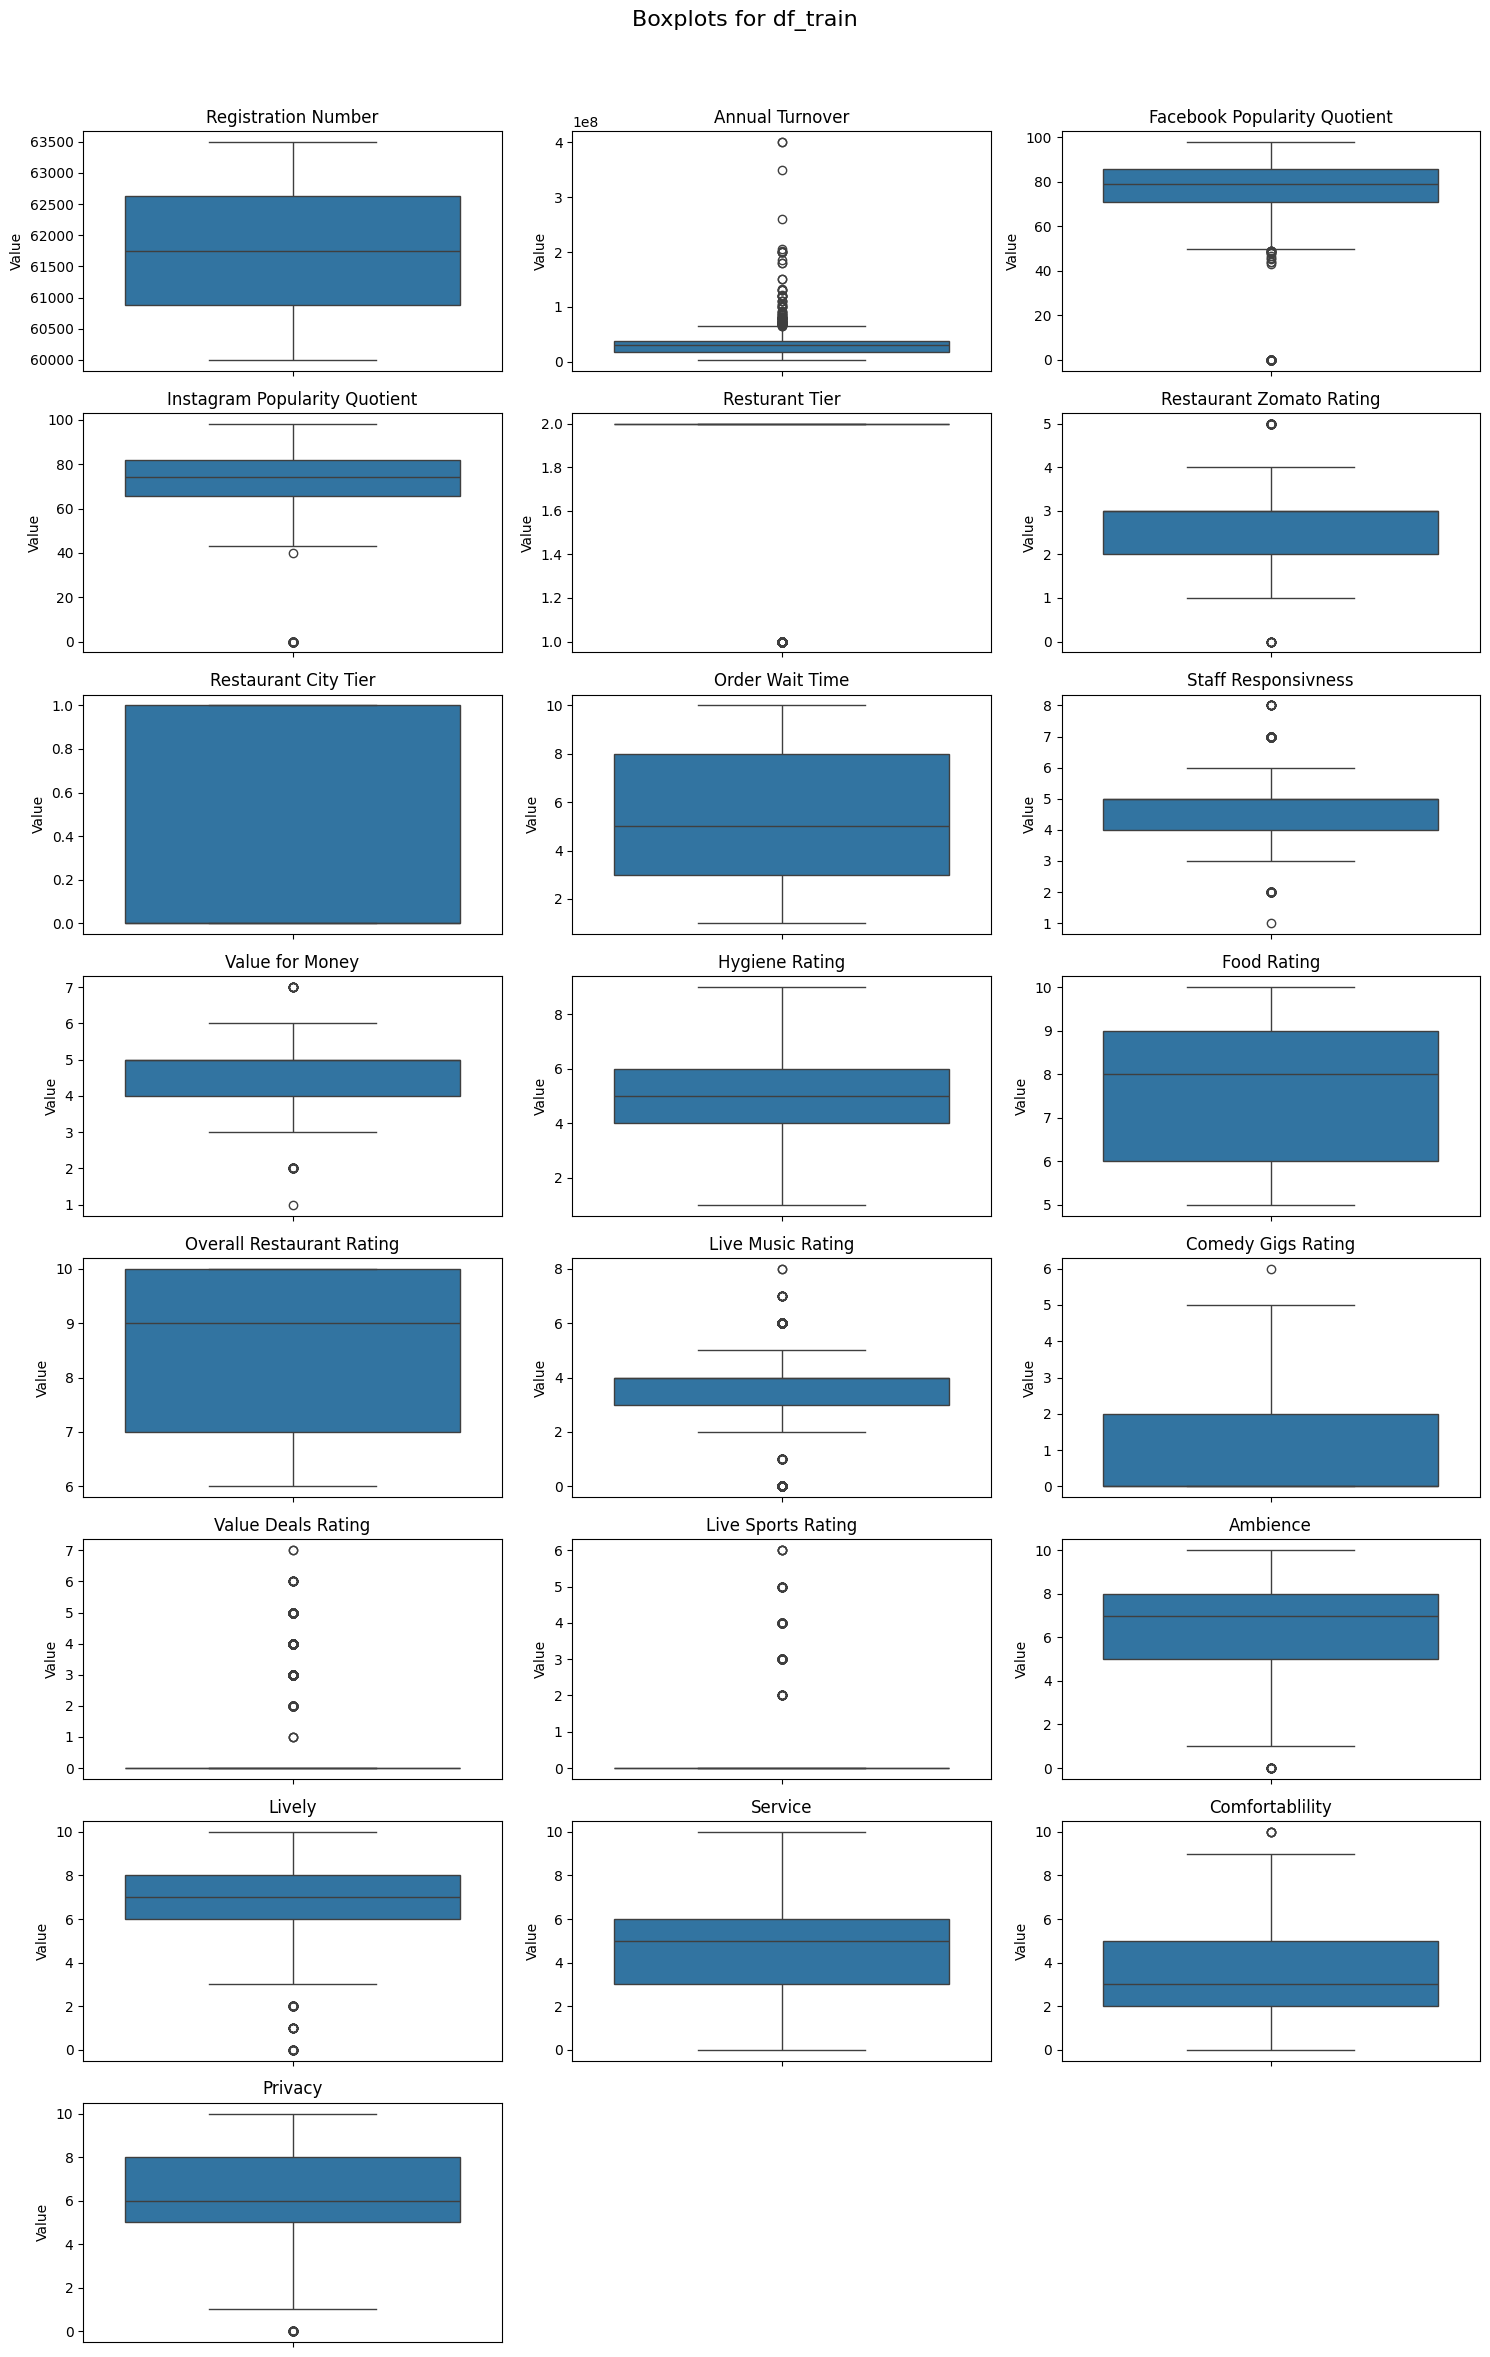

In [275]:
# Create boxplots for df_train
create_boxplots(df_train, 'Boxplots for df_train')

##### Annual Turnover outliers

In [276]:
df_train['Annual Turnover'].describe()

count    3.234000e+03
mean     3.072307e+07
std      2.129923e+07
min      3.500000e+06
25%      1.800000e+07
50%      3.000000e+07
75%      3.700000e+07
max      4.000000e+08
Name: Annual Turnover, dtype: float64

<Axes: >

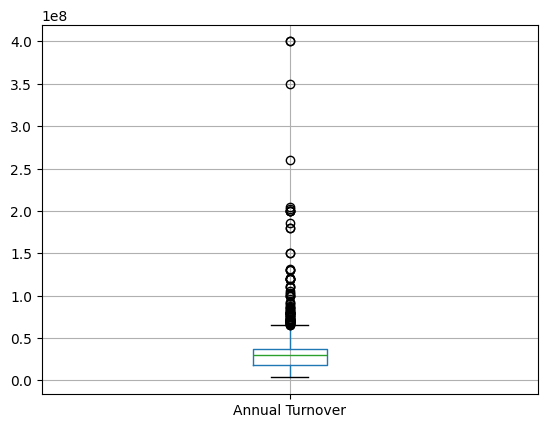

In [277]:
df_train.boxplot(column='Annual Turnover', return_type='axes')

In [278]:
df_train.shape

(3234, 41)

In [279]:
# Percentiles
upper_limit = df_train['Annual Turnover'].quantile(0.95)
print(upper_limit)
lower_limit = df_train['Annual Turnover'].quantile(0.05)
print(lower_limit)

# Remove outliers
df_train[(df_train['Annual Turnover'] <= upper_limit) & (df_train['Annual Turnover'] >= lower_limit)].shape

57000000.0
10000000.0


(2977, 41)

In [280]:
df_train = df_train[(df_train['Annual Turnover'] <= upper_limit) & (df_train['Annual Turnover'] >= lower_limit)]

<Axes: >

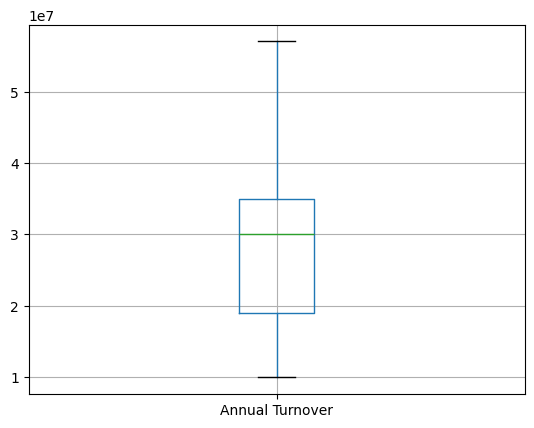

In [281]:
df_train.boxplot(column='Annual Turnover', return_type='axes')

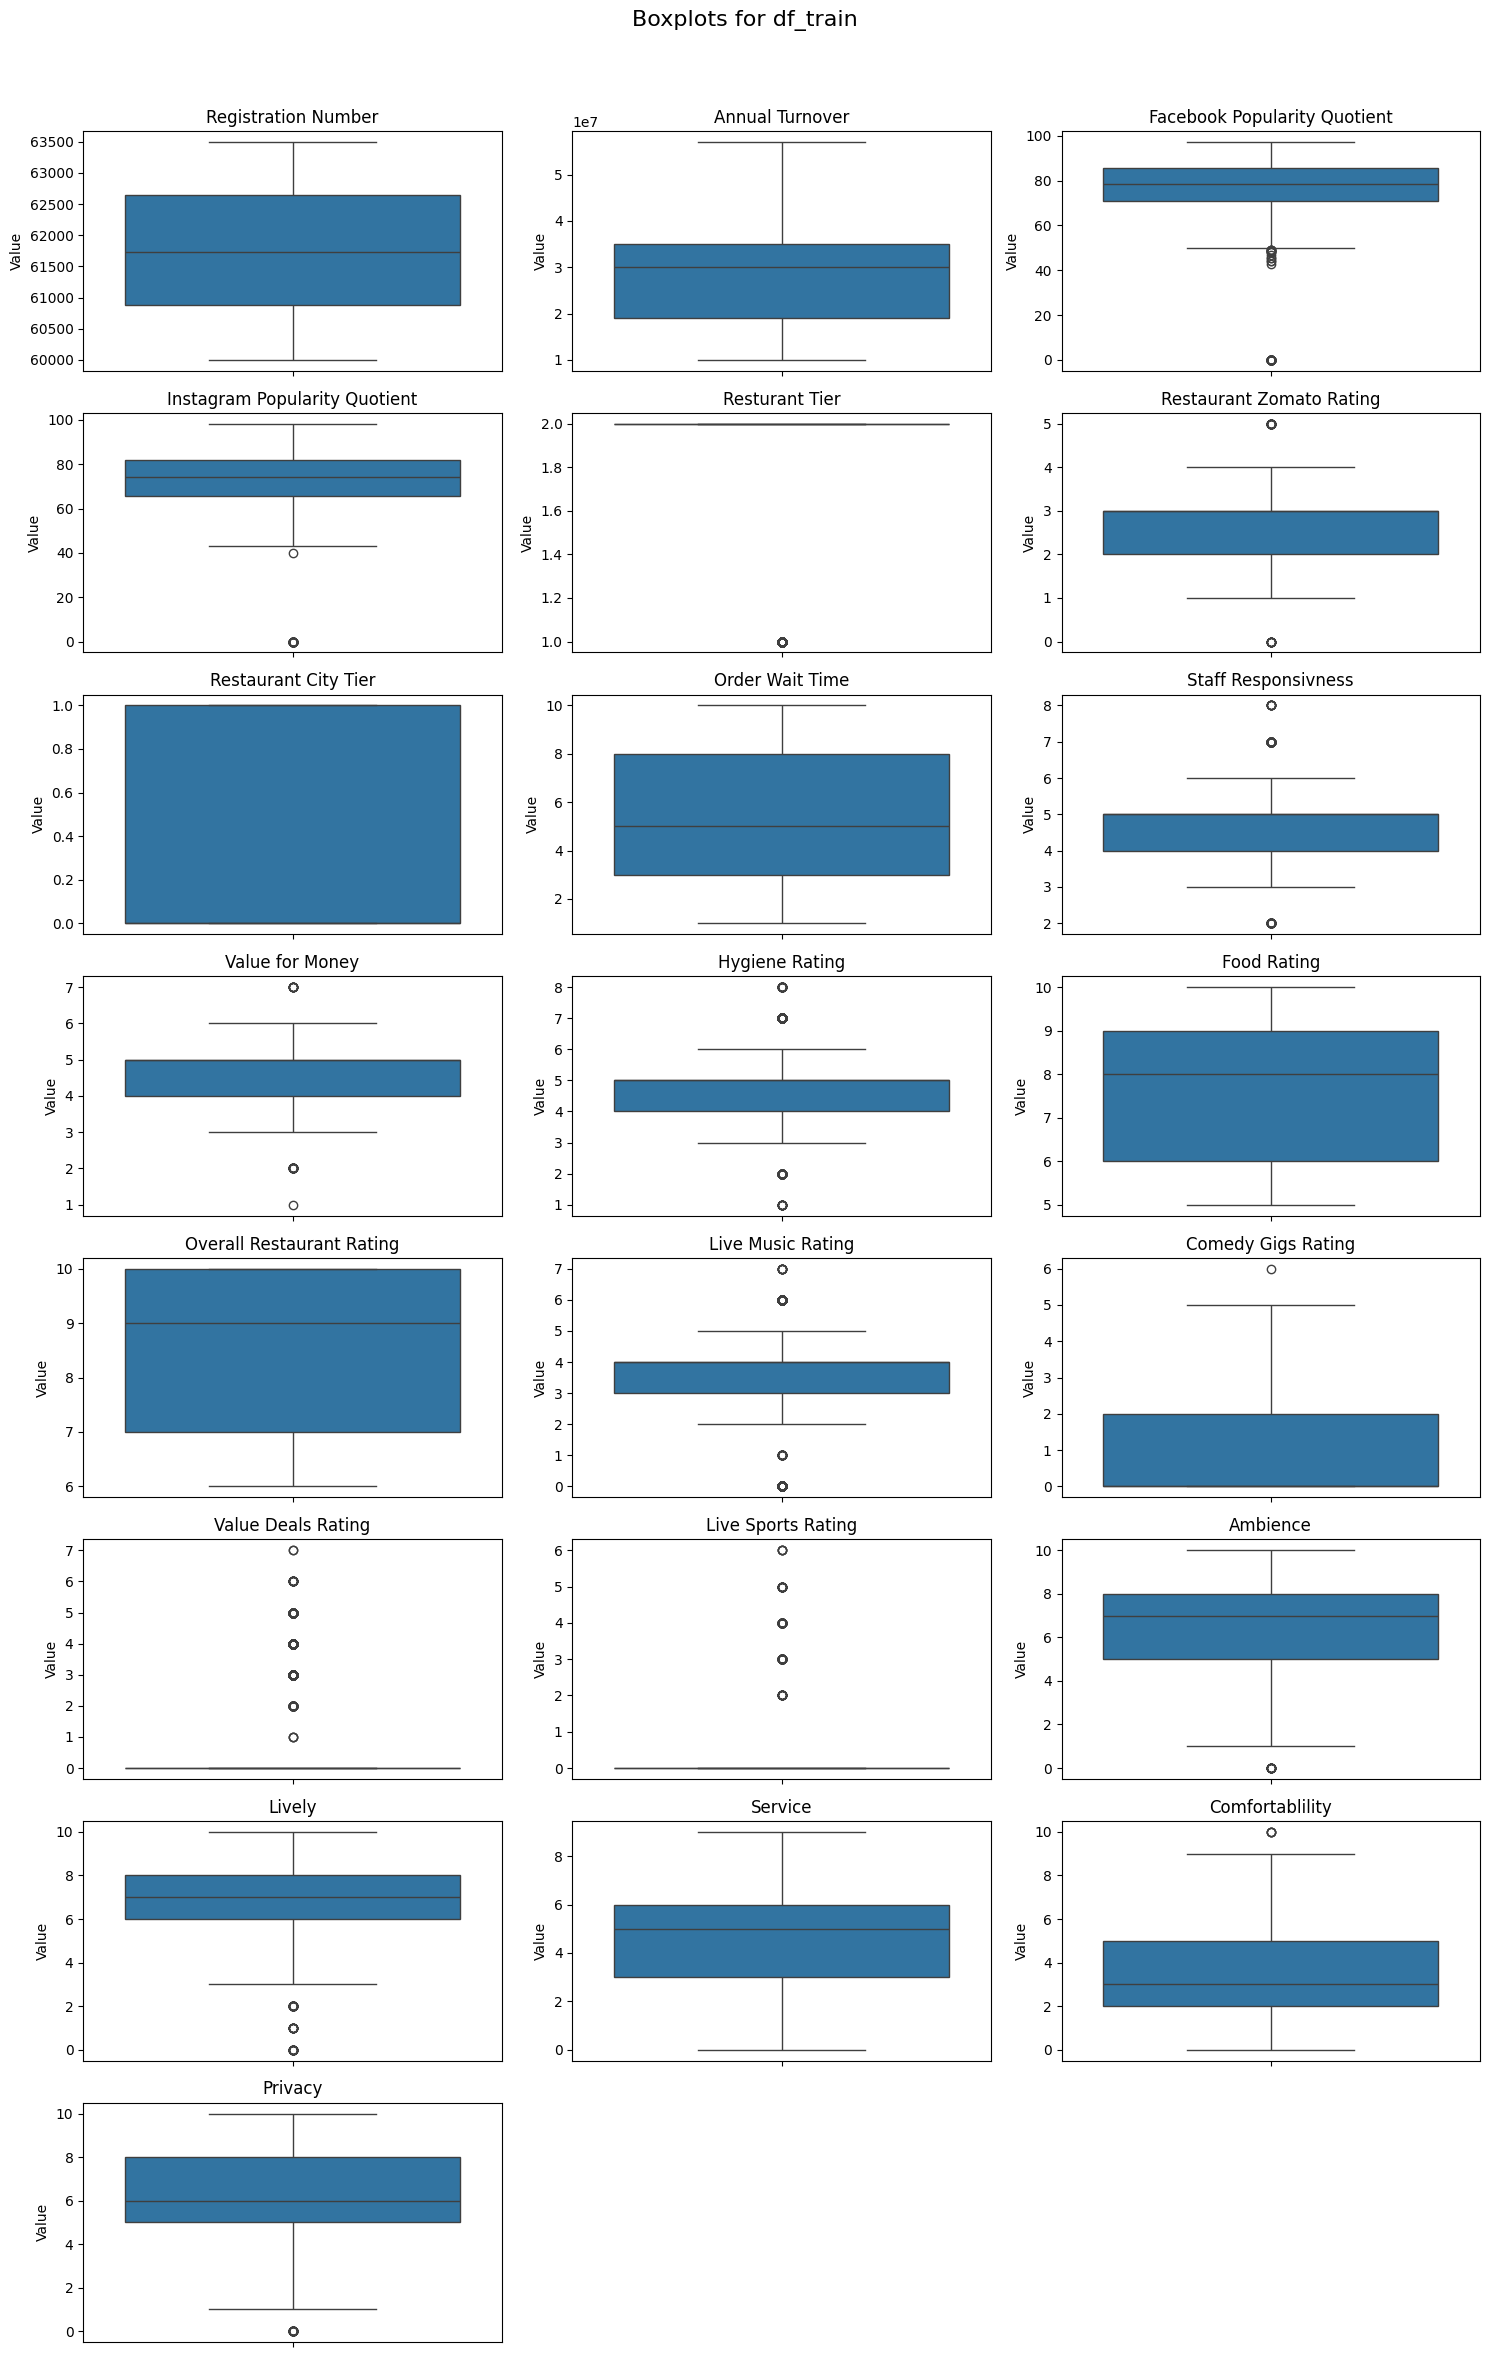

In [282]:
create_boxplots(df_train, 'Boxplots for df_train')

In [283]:
# Percentiles
upper_limit = df_train['Facebook Popularity Quotient'].quantile(0.98)
print(upper_limit)
lower_limit = df_train['Facebook Popularity Quotient'].quantile(0.02)
print(lower_limit)

# Values within limits
df_train[(df_train['Facebook Popularity Quotient'] <= upper_limit) & (df_train['Facebook Popularity Quotient'] >= lower_limit)].shape

93.3384
0.0


(2917, 41)

In [284]:
df_train = df_train[(df_train['Facebook Popularity Quotient'] <= upper_limit) & (df_train['Facebook Popularity Quotient'] >= lower_limit)]

<Axes: >

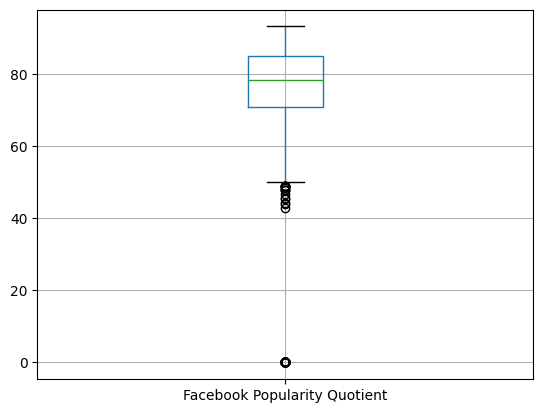

In [285]:
df_train.boxplot(column='Facebook Popularity Quotient', return_type='axes')

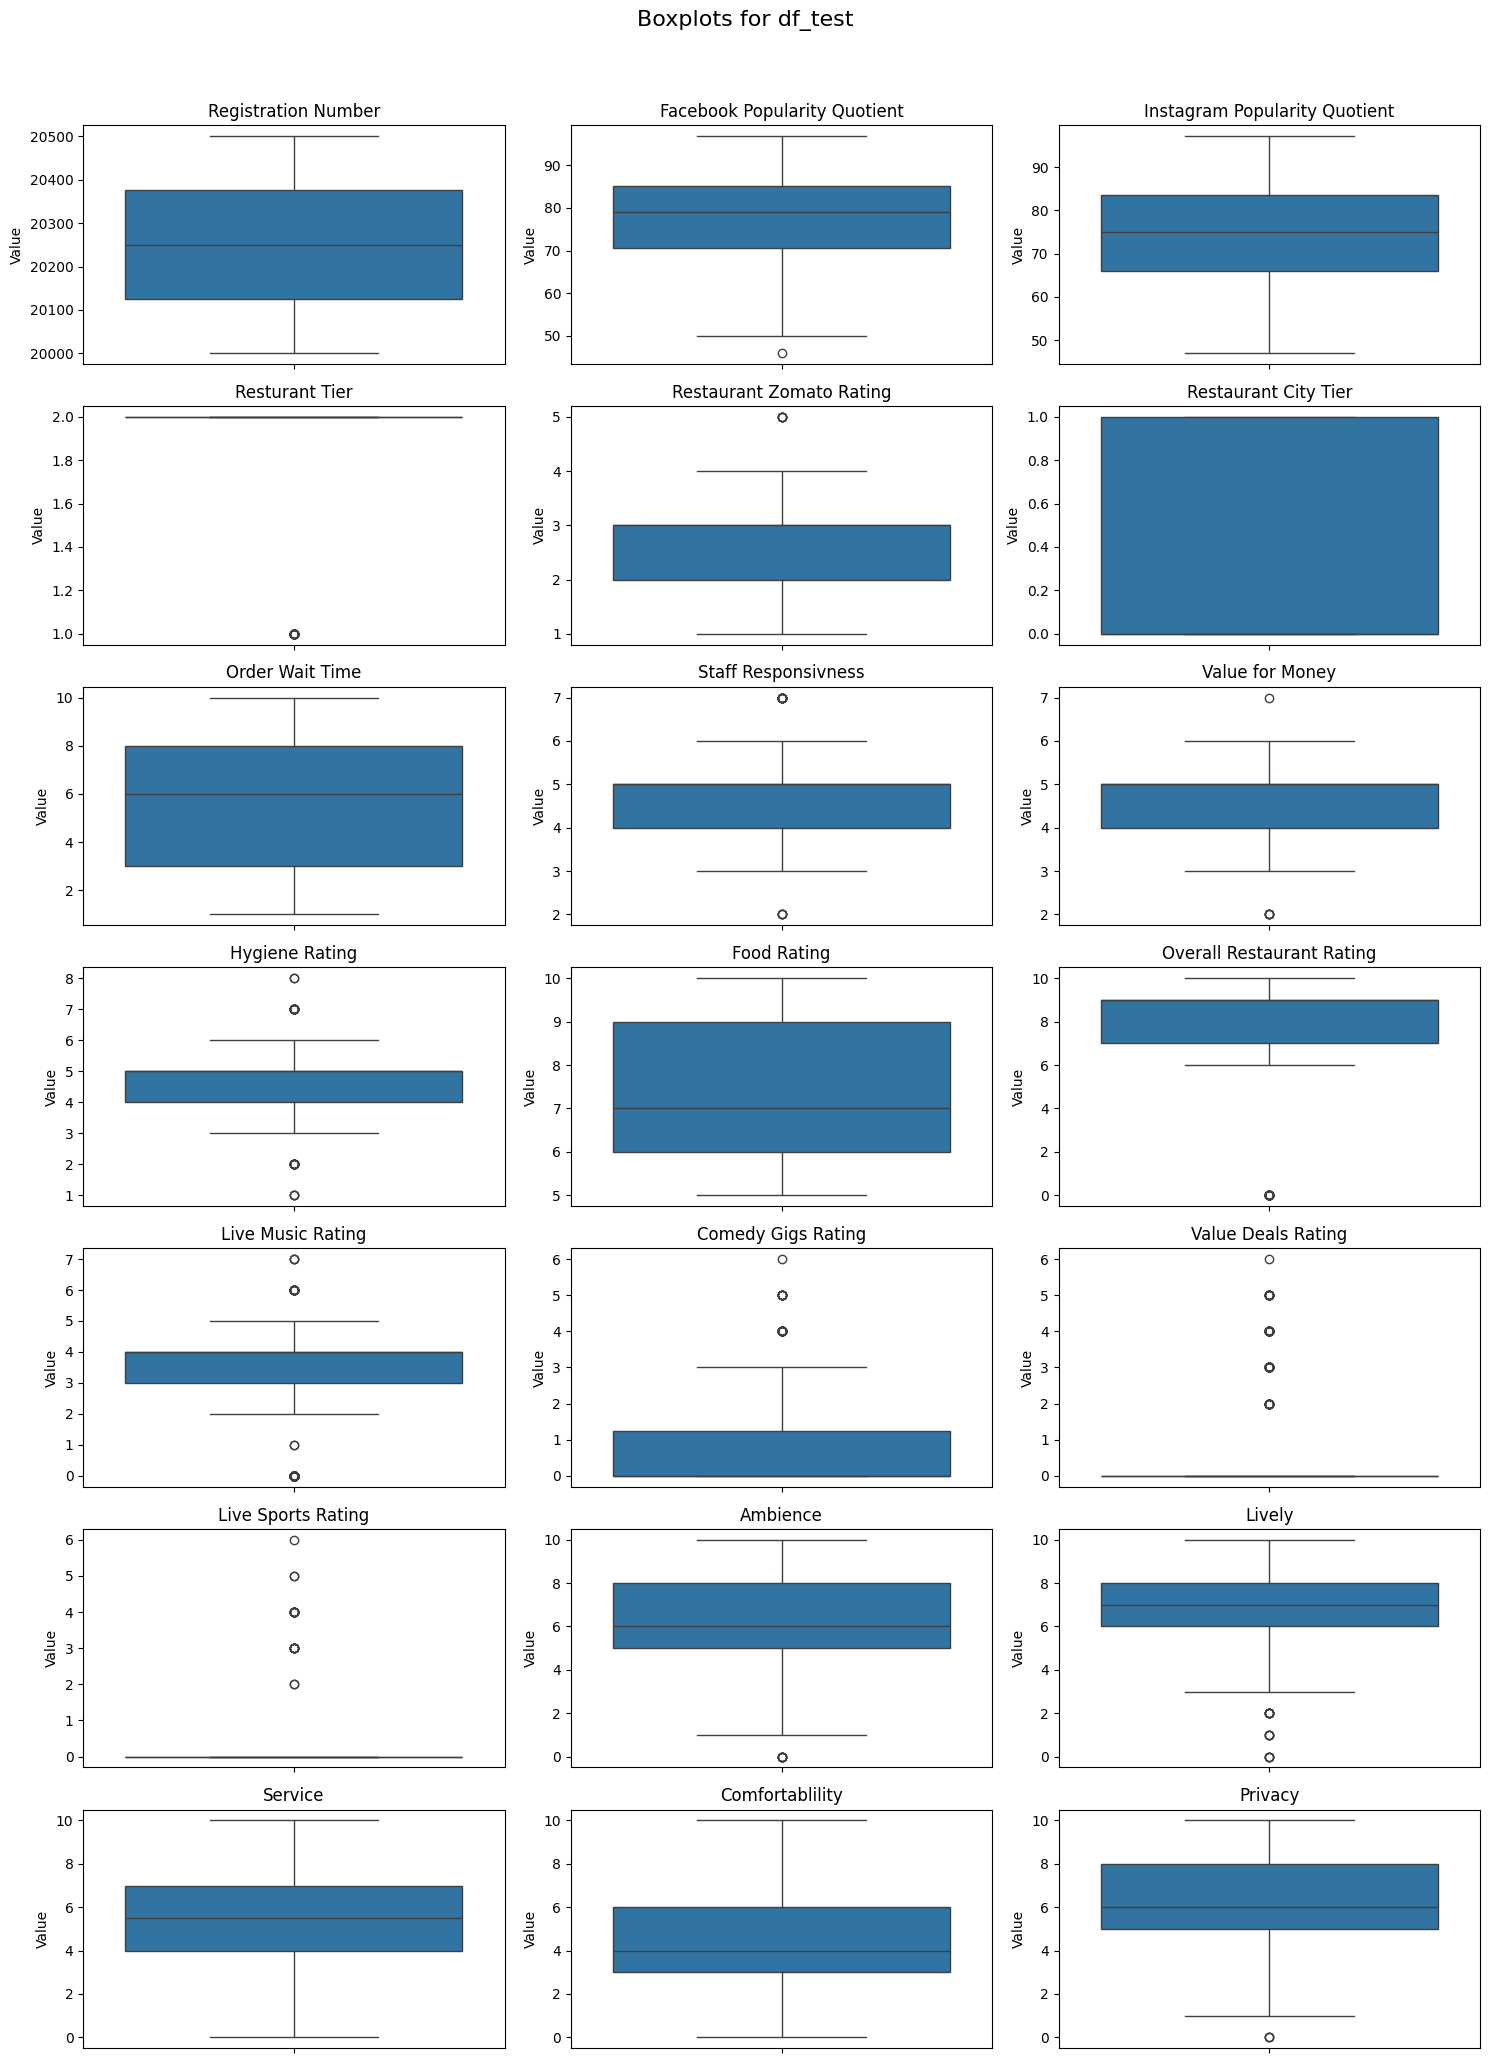

In [286]:
create_boxplots(df_test, 'Boxplots for df_test')

## 6. Feature Engineering
- Create New Features: Based on domain knowledge or interactions between existing features.
- Transform Features: Apply log transformation, scaling, or encoding.

### a) Create New Features

- Note:

Splitting cuisine and using alternate method of one hot encoding.

[Click here to open Explanaition Document](./Indepth%20Results\Steps%20to%20Process%20the%20Cuisine%20Column.docx) (Reference Alternate approach)

In [287]:
# Split 'Cuisine' into individual cuisines for both train and test datasets
cuisine_split_train = df_train['Cuisine'].str.split(',', expand=True)
cuisine_split_test = df_test['Cuisine'].str.split(',', expand=True)

# Rename columns for clarity
cuisine_split_train.columns = ['Cuisine_1', 'Cuisine_2']
cuisine_split_test.columns = ['Cuisine_1', 'Cuisine_2']

# Add the split columns back to the original dataframes (ensure proper alignment)
df_train = pd.concat([df_train.reset_index(drop=True), cuisine_split_train.reset_index(drop=True)], axis=1)
df_test = pd.concat([df_test.reset_index(drop=True), cuisine_split_test.reset_index(drop=True)], axis=1)

# Combine all unique cuisines from both train and test datasets
all_cuisines_train = pd.concat([df_train['Cuisine_1'], df_train['Cuisine_2']], ignore_index=True)
all_cuisines_test = pd.concat([df_test['Cuisine_1'], df_test['Cuisine_2']], ignore_index=True)
all_cuisines = pd.concat([all_cuisines_train, all_cuisines_test], ignore_index=True).dropna().unique()

# Create binary columns for each unique cuisine in both datasets
for cuisine in all_cuisines:
    df_train[cuisine] = df_train[['Cuisine_1', 'Cuisine_2']].apply(lambda x: cuisine in x.values, axis=1).astype(int)
    df_test[cuisine] = df_test[['Cuisine_1', 'Cuisine_2']].apply(lambda x: cuisine in x.values, axis=1).astype(int)

# Ensure both train and test datasets have all cuisine columns
for cuisine in all_cuisines:
    if cuisine not in df_train.columns:
        df_train[cuisine] = 0
    if cuisine not in df_test.columns:
        df_test[cuisine] = 0

# Reorder test columns to match train columns, excluding 'Annual Turnover'
feature_columns = [col for col in df_train.columns if col != 'Annual Turnover']
df_test = df_test[feature_columns]

# Drop temporary columns from both datasets
df_train.drop(columns=['Cuisine', 'Cuisine_1', 'Cuisine_2'], inplace=True, errors='ignore')
df_test.drop(columns=['Cuisine', 'Cuisine_1', 'Cuisine_2'], inplace=True, errors='ignore')

# Remove 'Cuisine', 'Cuisine_1', and 'Cuisine_2' from feature_columns if they exist
for col in ['Cuisine', 'Cuisine_1', 'Cuisine_2']:
    if col in feature_columns:
        feature_columns.remove(col)

# Verify column consistency
assert set(feature_columns) == set(df_test.columns), "Columns mismatch between train and test datasets"

- Note:

Splitting Cuisine might have been useless because it is not a significant variable

### b) Transform Features

In [288]:
df_train.head(2)

,Registration Number,Annual Turnover,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endorsed By,Instagram Popularity Quotient,Fire Audit,Liquor License Obtained,Situated in a Multi Complex,Dedicated Parking,Open Sitting Available,Resturant Tier,Restaurant Type,Restaurant Theme,Restaurant Zomato Rating,Restaurant City Tier,Order Wait Time,Staff Responsivness,Value for Money,Hygiene Rating,Food Rating,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy,Has Live Music,Has Comedy Gigs,Has Value Deals,Has Live Sports,Has FacebookQuotient,Has InstagramQuotient,City_Missing,indian,tibetan,algerian,peruvian,welsh,japanese,british,nigerian,polish,turkish,cuban,chinese,irish,swedish,hawaiian,italian,belgian,thai,cajun,greek,jewish,salvadorian,korean,sapnish,latvian
0,60001,42000000,bangalore,Near Business Hub,2009-02-14,84.3,Not Specific,95.8,True,True,True,False,True,2.0,Bar,Arabian,3,0,2,5,5,5,7,10.0,4.0,0.0,0.0,0.0,8.0,8,6,6,6,True,False,False,False,True,True,False,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,60002,50000000,indore,Near Party Hub,2008-09-29,85.4,Tier A Celebrity,85.0,True,True,True,True,False,2.0,Bar,Greek,3,0,6,6,6,7,8,9.0,0.0,4.0,0.0,0.0,5.0,7,7,3,8,False,True,False,False,True,True,False,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [289]:
df_train['Restaurant Location'].unique()

array(['Near Business Hub', 'Near Party Hub'], dtype=object)

In [290]:
# object columns
object_columns = df_train.select_dtypes(include=['object']).columns

# dummy variables
df_train = pd.get_dummies(df_train, columns=object_columns)

df_train.shape


(2917, 240)

In [291]:
# object columns
object_columns = df_test.select_dtypes(include=['object']).columns

# dummy variables
df_test = pd.get_dummies(df_test, columns=object_columns)

df_test.shape


(500, 155)

In [292]:
listcol=list(df_train.columns)
listcol.remove('Annual Turnover')

In [293]:
# Identify missing columns in the test dataset
missing_columns = set(listcol) - set(df_test.columns)

missing_columns = list(missing_columns)

# Create a dataframe with the missing columns, filled with zeros
missing_cols_df = pd.DataFrame(0, index=df_test.index, columns=missing_columns)

# Add the missing columns to the test dataset in one operation
df_test = pd.concat([df_test, missing_cols_df], axis=1)

# Ensure the column order matches the train dataset (optional)
df_test = df_test[listcol]


In [294]:
listcol=list(df_train.columns)
listcol.remove('Annual Turnover')

In [295]:
assert set(listcol) == set(df_test.columns), "Columns mismatch between train and test datasets"

#### Split the data

In [296]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['Annual Turnover']), 
                                                    df_train['Annual Turnover'], test_size=0.2, random_state=42)

In [297]:
df_test.shape

(500, 239)

#### Standard Scaler

In [298]:
scaler_columns = ['Facebook Popularity Quotient', 'Instagram Popularity Quotient', 'Resturant Tier', 'Restaurant Zomato Rating','Restaurant City Tier',
                  'Order Wait Time', 'Staff Responsivness', 'Value for Money', 'Hygiene Rating', 'Food Rating', 'Overall Restaurant Rating',
                  'Live Music Rating', 'Comedy Gigs Rating', 'Value Deals Rating', 'Live Sports Rating', 'Ambience', 'Lively']

In [299]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scaler_columns] = scaler.fit_transform(X_train[scaler_columns])  # Fit on train, transform train
X_test_scaled[scaler_columns] = scaler.transform(X_test[scaler_columns])  # Transform test (no fitting)


## 7. Target Variable Analysis
- Distribution: Examine the distribution of the target variable.
- Relationships: Analyze the relationship between the target variable and other features.

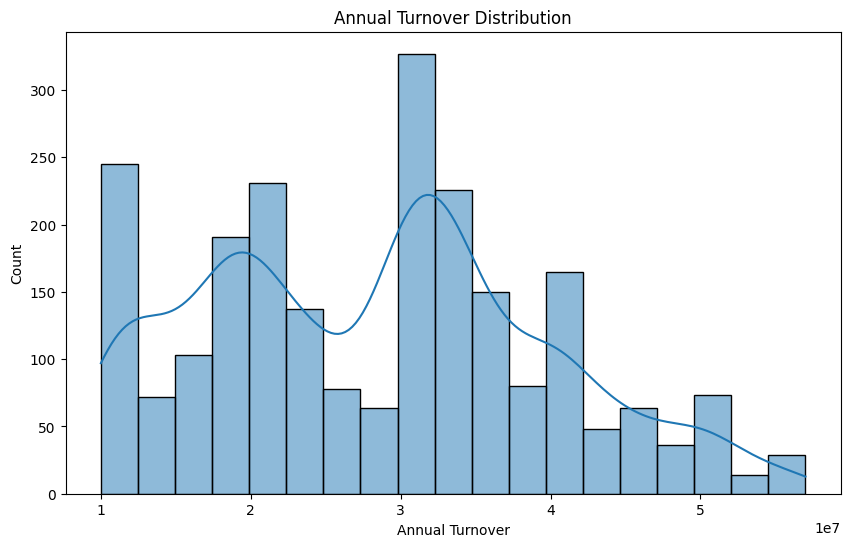

In [300]:
# Annual Turnover Distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True)
plt.title('Annual Turnover Distribution')
plt.xlabel('Annual Turnover')
plt.ylabel('Count')
plt.show()

# Regression Models

In [301]:
significant_columns = ['Hygiene Rating', 'Facebook Popularity Quotient', 'Instagram Popularity Quotient', 'Resturant Tier', 'Restaurant Zomato Rating',
                       'Live Music Rating', 'Has Live Music', 'City_Missing', 'Has FacebookQuotient', 'Has InstagramQuotient']

# get all columns that start with Restaurant Type_
restaurant_type_columns = [col for col in X_test_scaled.columns if col.startswith('Restaurant Type_')]

# get all columns that start with Endorsed By_
endorsed_by_columns = [col for col in X_test_scaled.columns if col.startswith('Endorsed By_')]

# get all columns that start with City_
city_columns = [col for col in X_test_scaled.columns if col.startswith('City_')]

# Combine all significant columns
significant_columns = significant_columns + restaurant_type_columns + endorsed_by_columns + city_columns

X_train_significant = X_train_scaled[significant_columns]
X_test_significant = X_test_scaled[significant_columns]

## Linear Regression

### Linear Regression Without Hyperparameters

In [302]:
# Create a baseline Linear Regression model
model = LinearRegression()

model.fit(X_train_significant, y_train)
# Predictions
y_pred = model.predict(X_test_significant)

# MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2 Score: {r2:.2f}')


Mean Absolute Error: 7968916.23
Mean Squared Error: 101807917352938.22
Root Mean Squared Error: 10089990.95
R^2 Score: 0.22


### Linear Regression With Hyperparameters

In [303]:
from sklearn.linear_model import Ridge

# Ridge Regression with Hyperparameter Tuning
ridge = Ridge()

# Hyperparameter Grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0] # Regularization strength
}

# Grid Search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_significant, y_train)

# Best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)
# Train the best model
best_ridge = grid_search.best_estimator_
y_pred = best_ridge.predict(X_test_significant)

# MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2 Score: {r2:.2f}')


Best Hyperparameters: {'alpha': 10.0}
Best R^2 Score: 0.22479523988484917
Mean Absolute Error: 8016853.65
Mean Squared Error: 101868612485575.12
Root Mean Squared Error: 10092998.19
R^2 Score: 0.21


## Random Forest Regressor

### Random Forest Regressor Without Hyperparameter

In [304]:
randomForest = RandomForestRegressor(random_state=42)
randomForest.fit(X_train_significant, y_train)

# Predictions
y_pred = randomForest.predict(X_test_significant)

# MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Absolute Error: 8466893.84
Mean Squared Error: 115041909863013.70
Root Mean Squared Error: 10725759.17
R^2 Score: 0.11


### Random Forest Regressor With Hyperparameter

# Define the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider for split
}

# Gridsearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_significant, y_train)

# Best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

# Train the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_significant)

# MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2 Score: {r2:.2f}')


Metric to measure

The measure of accuracy will be RMSE (Root mean square error)

The predicted Annual Turnover for each restaurant in the Test dataset will be compared with the actual Annual Turnover to calculate the RMSE value of the entire prediction. The lower the RMSE value, the better the model will be.

## Final Model

In [305]:
# Create a baseline Linear Regression model
model = LinearRegression()

model.fit(X_train_significant, y_train)
# Predictions
y_pred = model.predict(X_test_significant)

# MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2 Score: {r2:.2f}')


Mean Absolute Error: 7968916.23
Mean Squared Error: 101807917352938.22
Root Mean Squared Error: 10089990.95
R^2 Score: 0.22


In [306]:
import joblib

# Save the model
joblib.dump(model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [307]:
scaler = StandardScaler()

X_train_scaled[scaler_columns] = scaler.fit_transform(X_train[scaler_columns])  # Fit on train, transform train
df_test[scaler_columns] = scaler.transform(df_test[scaler_columns])


In [308]:
df_test[significant_columns].isna().sum().sort_values(ascending=False)

Hygiene Rating                   0
Facebook Popularity Quotient     0
Instagram Popularity Quotient    0
Resturant Tier                   0
Restaurant Zomato Rating         0
                                ..
City_vandavasi                   0
City_vapi                        0
City_varanasi                    0
City_vijayawada                  0
City_visakhapatnam               0
Length: 167, dtype: int64

In [309]:
# Predictions
y_pred = model.predict(df_test[significant_columns])

In [310]:
df_test['Registration Number']

0      20001
1      20002
2      20003
3      20004
4      20005
       ...  
495    20496
496    20497
497    20498
498    20499
499    20500
Name: Registration Number, Length: 500, dtype: int64

In [311]:
y_pred

array([31525611.97402946, 32581029.8163856 , 28211929.83865971,
       32868004.39569785, 40279010.93162265, 30673294.14489543,
       29207296.04845399, 23591232.2305032 , 23652350.66224215,
       29039005.45856124, 30293570.91739169, 32330232.97455678,
       28429441.32912908, 24856220.68418085, 19374374.91618495,
       32721511.7301726 , 33769123.80400384, 19670057.91195348,
       31473548.43197067, 30702859.77894574, 17699952.86567029,
       26827240.2823123 , 24314767.18596469, 27279624.18097509,
       31787959.15162902, 29857869.00644889, 36736357.65149993,
       31492648.46008111, 32908048.65988993, 26887250.23206385,
       33270201.52635939, 37253849.16536875, 27212031.85388002,
       28358854.37846501, 25339516.57550959, 25965984.68242604,
       35269723.14978579, 32868142.50338303, 20802837.25652551,
       26463750.07919426, 28130585.34916335, 31750230.3446707 ,
       26991607.17035874, 24244250.58402815, 29498566.15818284,
       23183848.72894167, 24137407.96701

In [312]:
results_df = pd.DataFrame({
    'Registration Number': df_test['Registration Number'],
    'Annual Turnover': y_pred
})

results_df.to_csv('predictions.csv', index=False)